In [224]:
# imports

import sqlite3
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import joblib

from sklearn.feature_selection import SelectKBest, f_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectKBest, f_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

In [225]:
# filter out warnings

warnings.filterwarnings('ignore')

In [226]:
# display settings (pandas)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

In [227]:
class NBAFeatureEngineer:
    def __init__(self, db_path='../data/raw/nba.sqlite'):
        self.db_path = db_path
        self.conn = None
        self.top_players = None
        self.player_data = None
        
    def connect(self):
        """Connect to database"""
        self.conn = sqlite3.connect(self.db_path)
        print(f"Connected to {self.db_path}")


In [228]:
# Intializes and connects

engineer = NBAFeatureEngineer()
engineer.connect()

Connected to ../data/raw/nba.sqlite


In [229]:
def load_top_players_from_eda(self):
    """
    Loads the top 20 players identified in EDA with 100+ games
    Based on analyze_2015_plus_suitability() findings
    """
    query = """
    SELECT
        pbp.player1_id,
        pbp.player1_name,
        COUNT(DISTINCT pbp.game_id) as games_played,
        COUNT(*) as total_actions,
        MIN(g.game_date) as first_game,
        MAX(g.game_date) as last_game,
        COUNT(DISTINCT SUBSTR(g.game_date, 1, 4)) as seasons_active
    FROM play_by_play pbp
    JOIN game g ON pbp.game_id = g.game_id
    WHERE g.game_date >= '2015-01-01'
    AND pbp.player1_id IS NOT NULL
    AND pbp.player1_id != '0'
    GROUP BY pbp.player1_id, pbp.player1_name
    HAVING COUNT(DISTINCT pbp.game_id) >= 100
    ORDER BY total_actions DESC
    LIMIT 20
    """
    
    self.top_players = pd.read_sql_query(query, self.conn)
    print(f"Loaded {len(self.top_players)} top players for modeling")
    return self.top_players

# Monkey patching method to class
NBAFeatureEngineer.load_top_players_from_eda = load_top_players_from_eda

In [230]:
# Loads top players from EDA analysis
top_players = engineer.load_top_players_from_eda()

# Display results
print(f"\nTop Players for Injury Prediction Modeling:")
display(top_players[['player1_name', 'games_played', 'total_actions', 'seasons_active']])

# Stores player names for reference
player_names = top_players['player1_name'].tolist()
print(f"\nPlayers selected: {', '.join(player_names[:5])}... (and {len(player_names)-5} more)")

Loaded 20 top players for modeling

Top Players for Injury Prediction Modeling:


,player1_name,games_played,total_actions,seasons_active
0,Giannis Antetokounmpo,661,30862,9
1,James Harden,672,29814,9
2,Russell Westbrook,643,29320,9
3,LeBron James,633,27857,9
4,Nikola Jokic,629,24239,9
5,DeMar DeRozan,644,23455,9
6,Anthony Davis,530,23407,9
7,Stephen Curry,610,22779,9
8,Damian Lillard,596,22426,9
9,Julius Randle,596,22244,9



Players selected: Giannis Antetokounmpo, James Harden, Russell Westbrook, LeBron James, Nikola Jokic... (and 15 more)


In [231]:
def load_player_game_data(self, start_date='2015-01-01', end_date='2023-06-12'):
    """
    Loads playergame level data for top players
    Based on EDA event type distributions and clean data filtering
    """
    # Gets player IDs for filtering
    if self.top_players is None:
        self.load_top_players_from_eda()
    
    player_ids = "', '".join(self.top_players['player1_id'].astype(str))
    
    query = f"""
    SELECT
        pbp.game_id,
        g.game_date,
        pbp.player1_id as player_id,
        pbp.player1_name as player_name,
        g.season_id,
        g.season_type,
        
        -- Total activity metrics
        COUNT(*) as total_actions,
        
        -- Event type breakdowns (based on EDA findings)
        -- Shooting Load (Types 1+2+3 = 37.4% of actions)
        SUM(CASE WHEN pbp.eventmsgtype = 1 THEN 1 ELSE 0 END) as made_shots,
        SUM(CASE WHEN pbp.eventmsgtype = 2 THEN 1 ELSE 0 END) as missed_shots,  
        SUM(CASE WHEN pbp.eventmsgtype = 3 THEN 1 ELSE 0 END) as free_throws,
        
        -- Defensive Load (Type 4 = 22.5% of actions)
        SUM(CASE WHEN pbp.eventmsgtype = 4 THEN 1 ELSE 0 END) as rebounds,
        
        -- Physical Contact Load (Types 6+3 = 18.7%)
        SUM(CASE WHEN pbp.eventmsgtype = 6 THEN 1 ELSE 0 END) as fouls,
        
        -- Ball Handling Stress (Type 5 = 6.1%)
        SUM(CASE WHEN pbp.eventmsgtype = 5 THEN 1 ELSE 0 END) as turnovers,
        
        -- Substitution tracking (Type 8 = 9.8%)
        SUM(CASE WHEN pbp.eventmsgtype = 8 THEN 1 ELSE 0 END) as substitutions,
        
        -- Other events
        SUM(CASE WHEN pbp.eventmsgtype NOT IN (1,2,3,4,5,6,8) THEN 1 ELSE 0 END) as other_events
        
    FROM play_by_play pbp
    JOIN game g ON pbp.game_id = g.game_id
    WHERE g.game_date >= '{start_date}'
    AND g.game_date <= '{end_date}'
    AND pbp.player1_id IN ('{player_ids}')
    AND pbp.player1_id IS NOT NULL
    AND pbp.player1_id != '0'
    AND g.season_type = 'Regular Season'  -- Focus on regular season for consistency
    GROUP BY pbp.game_id, pbp.player1_id, pbp.player1_name, g.game_date, g.season_id, g.season_type
    ORDER BY pbp.player1_id, g.game_date
    """
    
    # Loads data
    self.player_data = pd.read_sql_query(query, self.conn)
    
    # Convert game_date to datetime
    self.player_data['game_date'] = pd.to_datetime(self.player_data['game_date'])
    
    # Adds derived shooting metrics
    self.player_data['total_shot_attempts'] = (
        self.player_data['made_shots'] + self.player_data['missed_shots']
    )
    self.player_data['shooting_efficiency'] = (
        self.player_data['made_shots'] / 
        self.player_data['total_shot_attempts'].replace(0, np.nan)
    )
    
    return self.player_data

# Monkey patching method to class
NBAFeatureEngineer.load_player_game_data = load_player_game_data

In [232]:
# Loads player-game data
print("Loading player-game data based on EDA event type analysis...")

player_data = engineer.load_player_game_data()

print(f"Successfully loaded {len(player_data):,} player-game records")

Loading player-game data based on EDA event type analysis...
Successfully loaded 10,151 player-game records


In [233]:
# Displays loading summary
print("Play-Game Loading Summary")
print(f"- Total records: {len(player_data):,}")
print(f"- Unique players: {player_data['player_id'].nunique()}")
print(f"- Unique games: {player_data['game_id'].nunique()}")
print(f"- Date range: {player_data['game_date'].min().date()} to {player_data['game_date'].max().date()}")
print(f"- Seasons covered: {player_data['season_id'].nunique()}")

# Validates against EDA findings
print(f"\nEvent Type Validation (vs EDA findings):")
total_events = player_data[['made_shots', 'missed_shots', 'free_throws', 'rebounds', 'fouls', 'turnovers', 'substitutions']].sum().sum()
print(f"- Rebounds: {player_data['rebounds'].sum():,} ({player_data['rebounds'].sum()/total_events*100:.1f}% - EDA: 22.5%)")
print(f"- Missed shots: {player_data['missed_shots'].sum():,} ({player_data['missed_shots'].sum()/total_events*100:.1f}% - EDA: 20.2%)")
print(f"- Made shots: {player_data['made_shots'].sum():,} ({player_data['made_shots'].sum()/total_events*100:.1f}% - EDA: 17.2%)")

# Sample of data structure
print(f"\nSample Data Structure:")
display(player_data.head())

Play-Game Loading Summary
- Total records: 10,151
- Unique players: 20
- Unique games: 6592
- Date range: 2015-01-01 to 2023-04-09
- Seasons covered: 9

Event Type Validation (vs EDA findings):
- Rebounds: 84,065 (21.3% - EDA: 22.5%)
- Missed shots: 85,913 (21.8% - EDA: 20.2%)
- Made shots: 82,672 (21.0% - EDA: 17.2%)

Sample Data Structure:


,game_id,game_date,player_id,player_name,season_id,season_type,total_actions,made_shots,missed_shots,free_throws,rebounds,fouls,turnovers,substitutions,other_events,total_shot_attempts,shooting_efficiency
0,0021500029,2015-10-30,1626157,Karl-Anthony Towns,22015,Regular Season,47,11,8,7,14,3,1,3,0,19,0.578947
1,0021500050,2015-11-02,1626157,Karl-Anthony Towns,22015,Regular Season,30,5,4,0,5,5,4,3,4,9,0.555556
2,0021500071,2015-11-05,1626157,Karl-Anthony Towns,22015,Regular Season,25,3,10,0,4,3,0,3,2,13,0.230769
3,0021500085,2015-11-07,1626157,Karl-Anthony Towns,22015,Regular Season,40,8,10,1,13,4,0,4,0,18,0.444444
4,0021500101,2015-11-09,1626157,Karl-Anthony Towns,22015,Regular Season,34,5,2,8,12,3,2,2,0,7,0.714286


In [234]:
# Data Quality Check
print("Data Quality Check")

# Missing values
missing_data = player_data.isnull().sum()
if missing_data.any():
    print("Missing values found:")
    print(missing_data[missing_data > 0])
else:
    print("No missing values")

# Validates player distribution
print(f"\nGames Per Player Distribution:")
games_per_player = player_data.groupby(['player_id', 'player_name']).size().reset_index(name='games')
print(games_per_player.describe())

# Checks for data consistency
print(f"\nData Consistency Check:")
print(f"- Zero total_actions games: {(player_data['total_actions'] == 0).sum()}")
print(f"- Negative values: {(player_data.select_dtypes(include=[np.number]) < 0).sum().sum()}")
print(f"- Future dates: {(player_data['game_date'] > pd.Timestamp.now()).sum()}")

# Top active players (top 5)
print(f"\nTop 5 Active Players:")
top_active = games_per_player.nlargest(5, 'games')
display(top_active)

Data Quality Check
Missing values found:
shooting_efficiency    15
dtype: int64

Games Per Player Distribution:
            games
count   20.000000
mean   507.550000
std     60.039877
min    355.000000
25%    468.250000
50%    530.500000
75%    552.000000
max    571.000000

Data Consistency Check:
- Zero total_actions games: 0
- Negative values: 0
- Future dates: 0

Top 5 Active Players:


,player_id,player_name,games
5,201942,DeMar DeRozan,571
2,201566,Russell Westbrook,565
15,203507,Giannis Antetokounmpo,564
7,202696,Nikola Vucevic,556
12,203083,Andre Drummond,552


In [235]:
def create_rolling_workload_features(self, windows=[7, 14, 30]):
    """
    Creates rolling workload metrics based on EDA event type analysis
        7-day (recent), 14-day (medium), 30-day (long term)
    """
    if self.player_data is None:
        raise ValueError("PLayer data needs to be loaded before this")
    
    # Sort by player and date for rolling calculations
    df = self.player_data.sort_values(['player_id', 'game_date']).copy()
    
    # Feature columns
    feature_cols = []
    
    for window in windows:
        print(f"   Computing {window}-day rolling features...")
        
        # Rolling activity metrics
        df[f'total_actions_{window}d'] = df.groupby('player_id')['total_actions'].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
        )
        
        # For shooting load
        df[f'shooting_load_{window}d'] = df.groupby('player_id')[
            ['made_shots', 'missed_shots', 'free_throws']
        ].transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).sum()).sum(axis=1)

        # Defensive workload (22.5% of actions from EDA) 
        df[f'defensive_load_{window}d'] = df.groupby('player_id')['rebounds'].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).sum()
        )
        
        # Physical contact workload (18.7% from EDA)
        df[f'contact_load_{window}d'] = df.groupby('player_id')[
            ['fouls', 'free_throws']
        ].transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).sum()).sum(axis=1)
        
        # Ball handling stress
        df[f'turnover_load_{window}d'] = df.groupby('player_id')['turnovers'].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).sum()
        )
        
        # Substitution patterns (fatigue indicator)
        df[f'substitution_rate_{window}d'] = df.groupby('player_id')['substitutions'].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
        )
        
        # Adds to feature list
        feature_cols.extend([
            f'total_actions_{window}d',
            f'shooting_load_{window}d', 
            f'defensive_load_{window}d',
            f'contact_load_{window}d',
            f'turnover_load_{window}d',
            f'substitution_rate_{window}d'
        ])
    
    # Stores feature columns for reference
    self.workload_features = feature_cols
    self.player_data = df
    
    print(f"\nCreated {len(feature_cols)} rolling workload features")
    return df[['player_id', 'player_name', 'game_date'] + feature_cols]

# Monkey patching method to class
NBAFeatureEngineer.create_rolling_workload_features = create_rolling_workload_features

In [236]:
# Creates rolling workload features
print("Rolling Workload Features:")
print("\nBased on EDA event type distributions:")
print("- Shooting Load (37.4% of actions): made + missed shots + free throws")
print("- Defensive Load (22.5% of actions): rebounds") 
print("- Contact Load (18.7% of actions): fouls + free throws")
print("- Windows: 7-day (recent), 14-day (medium), 30-day (long-term)")

# Feature creation
rolling_features = engineer.create_rolling_workload_features(windows=[7, 14, 30])

# Displays sample results
print(f"\nSample Rolling Features:")
sample_player = engineer.player_data['player_name'].iloc[0]
sample_data = rolling_features[rolling_features['player_name'] == sample_player].head()
display(sample_data[['player_name', 'game_date', 'total_actions_7d', 'shooting_load_7d', 'defensive_load_7d']])

# Add this diagnostic code after your rolling features
sample_player = engineer.player_data[engineer.player_data['player_name'] == 'LeBron James'].copy()
sample_player = sample_player.sort_values('game_date').head(10)
print(sample_player[['player_name', 'game_date', 'total_actions', 'total_actions_7d', 'total_actions_30d']])

Rolling Workload Features:

Based on EDA event type distributions:
- Shooting Load (37.4% of actions): made + missed shots + free throws
- Defensive Load (22.5% of actions): rebounds
- Contact Load (18.7% of actions): fouls + free throws
- Windows: 7-day (recent), 14-day (medium), 30-day (long-term)
   Computing 7-day rolling features...
   Computing 14-day rolling features...
   Computing 30-day rolling features...

Created 18 rolling workload features

Sample Rolling Features:


,player_name,game_date,total_actions_7d,shooting_load_7d,defensive_load_7d
0,Karl-Anthony Towns,2015-10-30,NaN,0.0,NaN
1,Karl-Anthony Towns,2015-11-02,47.0,26.0,14.0
2,Karl-Anthony Towns,2015-11-05,38.5,35.0,19.0
3,Karl-Anthony Towns,2015-11-07,34.0,48.0,23.0
4,Karl-Anthony Towns,2015-11-09,35.5,67.0,36.0


       player_name  game_date  total_actions  total_actions_7d  \
9655  LeBron James 2015-01-16             61               NaN   
9656  LeBron James 2015-01-19             44         61.000000   
9657  LeBron James 2015-01-21             48         52.500000   
9658  LeBron James 2015-01-23             33         51.000000   
9659  LeBron James 2015-01-27             53         46.500000   
9660  LeBron James 2015-01-30             37         47.800000   
9661  LeBron James 2015-01-31             46         46.000000   
9662  LeBron James 2015-02-02             38         46.000000   
9663  LeBron James 2015-02-06             50         42.714286   
9664  LeBron James 2015-02-08             41         43.571429   

      total_actions_30d  
9655                NaN  
9656          61.000000  
9657          52.500000  
9658          51.000000  
9659          46.500000  
9660          47.800000  
9661          46.000000  
9662          46.000000  
9663          45.000000  
9664         

In [237]:
def create_usage_rate_features(self):
    """
    Creates usage rate and intensity features
    Based on total actions and efficiency metrics from EDA
    """
    if self.player_data is None:
        raise ValueError("PLayer data needs to be loaded before this")
        
    df = self.player_data.copy()
    
    # Actions per game intensity
    df['actions_per_game_intensity'] = df['total_actions'] / df.groupby('player_id')['total_actions'].transform('mean')
    
    # Shooting usage rate
    df['shooting_usage_rate'] = df['total_shot_attempts'] / df['total_actions']
    
    # Defensive usage rate  
    df['defensive_usage_rate'] = df['rebounds'] / df['total_actions']
    
    # Physical involvement rate
    df['contact_usage_rate'] = (df['fouls'] + df['free_throws']) / df['total_actions']
    
    # Ball security rate (lower turnovers = better)
    df['ball_security_rate'] = 1 - (df['turnovers'] / df['total_actions'].replace(0, np.nan))
    
    # Game flow involvement (substitutions indicate fatigue/performance)
    df['substitution_frequency'] = df['substitutions'] / df['total_actions']
    
    usage_features = [
        'actions_per_game_intensity',
        'shooting_usage_rate', 
        'defensive_usage_rate',
        'contact_usage_rate',
        'ball_security_rate',
        'substitution_frequency'
    ]
    
    self.usage_features = usage_features
    self.player_data = df
    
    print(f"\nCreated {len(usage_features)} usage rate features")
    return df[['player_id', 'player_name', 'game_date'] + usage_features]

# Monkey patching method to class
NBAFeatureEngineer.create_usage_rate_features = create_usage_rate_features

In [238]:
# Creates usage rate features
print("Usage Rate Features:")
print("Intensity and efficiency metrics:")
print("- Actions per game intensity (vs player average)")
print("- Usage rates by activity type (shooting, defense, contact)")
print("- Ball security and substitution patterns")

# Feature creation
usage_features = engineer.create_usage_rate_features()

# Displays sample results and distributions
print(f"\nSample Usage Features:")
display(usage_features.head())

print(f"\nUsage Rates Distribution:")
usage_cols = ['shooting_usage_rate', 'defensive_usage_rate', 'contact_usage_rate']
for col in usage_cols:
    mean_val = engineer.player_data[col].mean()
    std_val = engineer.player_data[col].std()
    print(f"- {col}: μ={mean_val:.3f}, σ={std_val:.3f}")

Usage Rate Features:
Intensity and efficiency metrics:
- Actions per game intensity (vs player average)
- Usage rates by activity type (shooting, defense, contact)
- Ball security and substitution patterns

Created 6 usage rate features

Sample Usage Features:


,player_id,player_name,game_date,actions_per_game_intensity,shooting_usage_rate,defensive_usage_rate,contact_usage_rate,ball_security_rate,substitution_frequency
0,1626157,Karl-Anthony Towns,2015-10-30,1.111438,0.404255,0.297872,0.212766,0.978723,0.063830
1,1626157,Karl-Anthony Towns,2015-11-02,0.709429,0.300000,0.166667,0.166667,0.866667,0.100000
2,1626157,Karl-Anthony Towns,2015-11-05,0.591191,0.520000,0.160000,0.120000,1.000000,0.120000
3,1626157,Karl-Anthony Towns,2015-11-07,0.945905,0.450000,0.325000,0.125000,1.000000,0.100000
4,1626157,Karl-Anthony Towns,2015-11-09,0.804019,0.205882,0.352941,0.323529,0.941176,0.058824



Usage Rates Distribution:
- shooting_usage_rate: μ=0.426, σ=0.121
- defensive_usage_rate: μ=0.210, σ=0.100
- contact_usage_rate: μ=0.218, σ=0.090


In [239]:
# CORRECTED VERSION - Only use historical data
def create_workload_comparison_features(self):
    """
    Creates workload comparison features
    """
    if self.player_data is None:
        raise ValueError("Player data needs to be loaded before this")
        
    df = self.player_data.sort_values(['player_id', 'game_date']).copy()
    
    # FIXED: Season averages using only PREVIOUS games
    df['player_season_avg_actions'] = df.groupby(['player_id', 'season_id'])['total_actions'].transform(
        lambda x: x.shift(1).expanding(min_periods=1).mean()
    )
    df['player_career_avg_actions'] = df.groupby('player_id')['total_actions'].transform(
        lambda x: x.shift(1).expanding(min_periods=1).mean()
    )
    
    # FIXED: Current vs historical comparisons 
    df['actions_vs_season_avg'] = df['total_actions'] / df['player_season_avg_actions']
    df['actions_vs_career_avg'] = df['total_actions'] / df['player_career_avg_actions']
    
    # FIXED: Shooting workload comparisons
    df['player_season_avg_shots'] = df.groupby(['player_id', 'season_id'])['total_shot_attempts'].transform(
        lambda x: x.shift(1).expanding(min_periods=1).mean()
    )
    df['shots_vs_season_avg'] = df['total_shot_attempts'] / df['player_season_avg_shots']
    
    # FIXED: Defensive workload comparisons  
    df['player_season_avg_rebounds'] = df.groupby(['player_id', 'season_id'])['rebounds'].transform(
        lambda x: x.shift(1).expanding(min_periods=1).mean()
    )
    df['rebounds_vs_season_avg'] = df['rebounds'] / df['player_season_avg_rebounds']
    
    # Handle NaN values for first games 
    df[['actions_vs_season_avg', 'actions_vs_career_avg', 'shots_vs_season_avg', 'rebounds_vs_season_avg']] = \
    df[['actions_vs_season_avg', 'actions_vs_career_avg', 'shots_vs_season_avg', 'rebounds_vs_season_avg']].fillna(1.0)
    
    comparison_features = [
        'actions_vs_season_avg',
        'actions_vs_career_avg', 
        'shots_vs_season_avg',
        'rebounds_vs_season_avg'
    ]
    
    self.comparison_features = comparison_features
    self.player_data = df
    
    print(f"Created {len(comparison_features)} NON-LEAKING workload comparison features")
    return df[['player_id', 'player_name', 'game_date'] + comparison_features]

# Monkey patching method to class
NBAFeatureEngineer.create_workload_comparison_features = create_workload_comparison_features

In [240]:
# Creates workload comparison features
print("Workload Comparison Features:")
print("Current performance vs historical baselines:")
print("- Actions vs season/career averages")
print("- Shooting volume comparisons")
print("- Defensive activity comparisons")

# Feature creation
comparison_features = engineer.create_workload_comparison_features()

# Displays sample results
print(f"\nSample Comparison Features:")
display(comparison_features.head())

# Shows interesting patterns
print(f"\nWorkload Anomaly Detection:")
high_load_games = engineer.player_data[engineer.player_data['actions_vs_season_avg'] > 1.5]
low_load_games = engineer.player_data[engineer.player_data['actions_vs_season_avg'] < 0.5]
print(f"- High load games (>150% of season avg): {len(high_load_games):,}")
print(f"- Low load games (<50% of season avg): {len(low_load_games):,}")

Workload Comparison Features:
Current performance vs historical baselines:
- Actions vs season/career averages
- Shooting volume comparisons
- Defensive activity comparisons
Created 4 NON-LEAKING workload comparison features

Sample Comparison Features:


,player_id,player_name,game_date,actions_vs_season_avg,actions_vs_career_avg,shots_vs_season_avg,rebounds_vs_season_avg
0,1626157,Karl-Anthony Towns,2015-10-30,1.000000,1.000000,1.000000,1.000000
1,1626157,Karl-Anthony Towns,2015-11-02,0.638298,0.638298,0.473684,0.357143
2,1626157,Karl-Anthony Towns,2015-11-05,0.649351,0.649351,0.928571,0.421053
3,1626157,Karl-Anthony Towns,2015-11-07,1.176471,1.176471,1.317073,1.695652
4,1626157,Karl-Anthony Towns,2015-11-09,0.957746,0.957746,0.474576,1.333333



Workload Anomaly Detection:
- High load games (>150% of season avg): 242
- Low load games (<50% of season avg): 155


Feature Correlation Analysis
Analyzing correlations of 28 features...

High Correlations (>0.8):
- defensive_load_14d vs defensive_load_30d: 0.962
- defensive_load_7d vs defensive_load_14d: 0.960
- total_actions_14d vs total_actions_30d: 0.954
- substitution_rate_7d vs substitution_rate_14d: 0.950
- substitution_rate_14d vs substitution_rate_30d: 0.948
- shooting_load_7d vs shooting_load_14d: 0.948
- total_actions_7d vs total_actions_14d: 0.947
- shooting_load_14d vs shooting_load_30d: 0.940
- contact_load_14d vs contact_load_30d: 0.931
- turnover_load_14d vs turnover_load_30d: 0.929
- contact_load_7d vs contact_load_14d: 0.925
- defensive_load_7d vs defensive_load_30d: 0.911
- turnover_load_7d vs turnover_load_14d: 0.908
- total_actions_7d vs total_actions_30d: 0.892
- substitution_rate_7d vs substitution_rate_30d: 0.882
- actions_vs_season_avg vs actions_vs_career_avg: 0.875
- shooting_load_7d vs shooting_load_30d: 0.862
- contact_load_7d vs contact_load_30d: 0.837
- actions_per_game

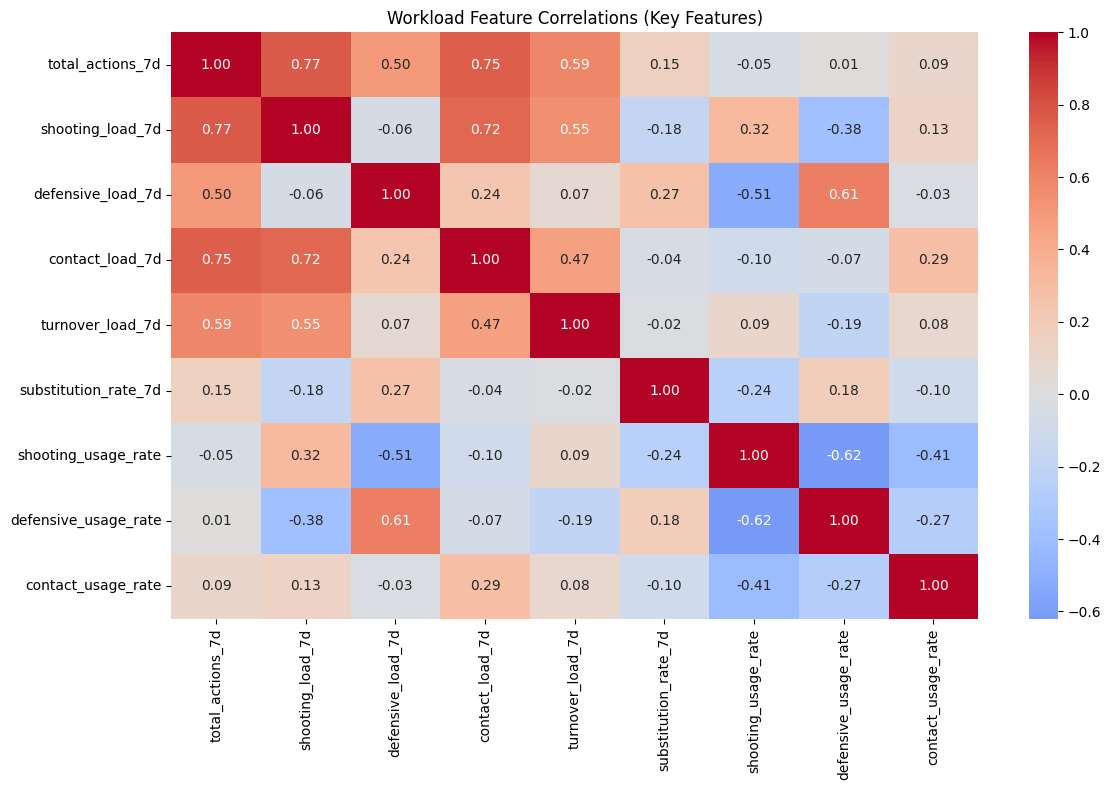

In [241]:
# Analyzes feature correlations and multicollinearity
print("Feature Correlation Analysis")

# Combines all of the workload features
all_workload_features = []
if hasattr(engineer, 'workload_features'):
    all_workload_features.extend(engineer.workload_features)
if hasattr(engineer, 'usage_features'):
    all_workload_features.extend(engineer.usage_features)
if hasattr(engineer, 'comparison_features'):
    all_workload_features.extend(engineer.comparison_features)

print(f"Analyzing correlations of {len(all_workload_features)} features...")

# Correlation matrix
feature_data = engineer.player_data[all_workload_features].corr()

# Finds high correlations (for potential multicollinearity)
print(f"\nHigh Correlations (>0.8):")
high_corr_pairs = []
for i in range(len(feature_data.columns)):
    for j in range(i+1, len(feature_data.columns)):
        corr_val = abs(feature_data.iloc[i,j])
        if corr_val > 0.8:
            high_corr_pairs.append({
                'feature1': feature_data.columns[i],
                'feature2': feature_data.columns[j], 
                'correlation': corr_val
            })

if high_corr_pairs:
    for pair in sorted(high_corr_pairs, key=lambda x: x['correlation'], reverse=True):
        print(f"- {pair['feature1']} vs {pair['feature2']}: {pair['correlation']:.3f}")
else:
    print("No high correlations found")

# Correlation heatmap for key features
plt.figure(figsize=(12, 8))
key_features = [f for f in all_workload_features if '7d' in f or 'usage' in f][:15]
sns.heatmap(engineer.player_data[key_features].corr(), 
            annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Workload Feature Correlations (Key Features)')
plt.tight_layout()
plt.show()

In [242]:
def generate_workload_summary(self):
    """A summary of workload features created"""
    if not hasattr(self, 'workload_features'):
        print("No workload features created yet")
        return
        
    print("Workload Feature Engineering Summary:")
    
    print(f"\nDataset Overview:")
    print(f"- Records: {len(self.player_data):,} player-game records")
    print(f"- Players: {self.player_data['player_id'].nunique()}")
    print(f"- Date range: {self.player_data['game_date'].min().date()} to {self.player_data['game_date'].max().date()}")
    
    print(f"\nFeatures Created:")
    if hasattr(self, 'workload_features'):
        print(f"- Rolling workload features: {len(self.workload_features)}")
    if hasattr(self, 'usage_features'):
        print(f"- Usage rate features: {len(self.usage_features)}")
    if hasattr(self, 'comparison_features'):
        print(f"- Workload comparison features: {len(self.comparison_features)}")
    
    total_features = 0
    if hasattr(self, 'workload_features'):
        total_features += len(self.workload_features)
    if hasattr(self, 'usage_features'):
        total_features += len(self.usage_features)
    if hasattr(self, 'comparison_features'):
        total_features += len(self.comparison_features)
    
    print(f"\nTotal Workload Features: {total_features}")
    
    # Sample feature values
    print(f"\nSample Features (7 day averages):")
    sample_cols = ['player_name', 'game_date', 'total_actions_7d', 'shooting_load_7d', 'defensive_load_7d']
    sample_data = self.player_data[sample_cols].head(5)
    display(sample_data)
    
    # Feature statistics
    print(f"\nFeature Statistics:")
    if hasattr(self, 'workload_features'):
        for feature in self.workload_features[:6]:  # Show first 6
            mean_val = self.player_data[feature].mean()
            std_val = self.player_data[feature].std()
            print(f"- {feature}: μ={mean_val:.2f}, σ={std_val:.2f}")

# Monkey patching method to class
NBAFeatureEngineer.generate_workload_summary = generate_workload_summary
engineer.generate_workload_summary()

Workload Feature Engineering Summary:

Dataset Overview:
- Records: 10,151 player-game records
- Players: 20
- Date range: 2015-01-01 to 2023-04-09

Features Created:
- Rolling workload features: 18
- Usage rate features: 6
- Workload comparison features: 4

Total Workload Features: 28

Sample Features (7 day averages):


,player_name,game_date,total_actions_7d,shooting_load_7d,defensive_load_7d
0,Karl-Anthony Towns,2015-10-30,NaN,0.0,NaN
1,Karl-Anthony Towns,2015-11-02,47.0,26.0,14.0
2,Karl-Anthony Towns,2015-11-05,38.5,35.0,19.0
3,Karl-Anthony Towns,2015-11-07,34.0,48.0,23.0
4,Karl-Anthony Towns,2015-11-09,35.5,67.0,36.0



Feature Statistics:
- total_actions_7d: μ=39.16, σ=7.61
- shooting_load_7d: μ=158.01, σ=43.56
- defensive_load_7d: μ=57.67, σ=24.40
- contact_load_7d: μ=60.80, σ=20.74
- turnover_load_7d: μ=19.54, σ=7.82
- substitution_rate_7d: μ=2.38, σ=1.03


In [243]:
def create_performance_decline_features(self):
    """
    Creates performance decline indicators based on current vs historical patterns
    Enhanced version of existing logic with additional fatigue indicators
    """
    if self.player_data is None:
        raise ValueError("Player data needs to be loaded before this")
    
    df = self.player_data.sort_values(['player_id', 'game_date']).copy()
    
    print("Creating performance decline features...")
    
    # Enhanced Performance Drop Indicators
    print("- Computing performance drop indicators...")
    
    # 7 day vs 30 day performance comparison
    df['performance_drop_7vs30'] = (
        df['total_actions_7d'] / df['total_actions_30d'].replace(0, np.nan)
    )
    
    # Current game vs rolling averages
    df['current_vs_7day_avg'] = (
        df['total_actions'] / df['total_actions_7d'].replace(0, np.nan)
    )
    
    df['current_vs_14day_avg'] = (
        df['total_actions'] / df.groupby('player_id')['total_actions'].transform(
            lambda x: x.rolling(window=14, min_periods=1).mean()
        ).replace(0, np.nan)
    )
    
    # Shooting efficiency decline
    df['shooting_eff_7d'] = df.groupby('player_id')['shooting_efficiency'].transform(
        lambda x: x.rolling(window=7, min_periods=1).mean()
    )
    
    df['shooting_eff_decline'] = (
        df['shooting_efficiency'] - df['shooting_eff_7d']
    )
    
    # Consecutive low performance games
    print("- Computing consecutive performance patterns...")
    
    # Defines low performance (below 70% of personal average)
    df['personal_avg_actions'] = df.groupby('player_id')['total_actions'].transform('mean')
    df['is_low_performance'] = df['total_actions'] < (df['personal_avg_actions'] * 0.7)
    
    # Counts consecutive low games
    df['consecutive_low_games'] = 0
    for player_id in df['player_id'].unique():
        player_mask = df['player_id'] == player_id
        player_df = df[player_mask].copy()
        
        # Calculates consecutive low games
        consecutive = 0
        consecutive_counts = []
        
        for is_low in player_df['is_low_performance']:
            if is_low:
                consecutive += 1
            else:
                consecutive = 0
            consecutive_counts.append(consecutive)
        
        df.loc[player_mask, 'consecutive_low_games'] = consecutive_counts
    
    # Performance trend indicators
    print("- Computing performance trends...")
    
    # 7 day trend in total actions
    df['actions_trend_7d'] = df.groupby('player_id')['total_actions'].transform(
        lambda x: x.rolling(window=7, min_periods=3).apply(
            lambda y: np.polyfit(range(len(y)), y, 1)[0] if len(y) >= 3 else 0
        )
    )
    
    # Efficiency trend
    df['efficiency_trend_7d'] = df.groupby('player_id')['shooting_efficiency'].transform(
        lambda x: x.rolling(window=7, min_periods=3).apply(
            lambda y: np.polyfit(range(len(y)), y.fillna(y.mean()), 1)[0] if len(y) >= 3 else 0
        )
    )
    
    decline_features = [
        'performance_drop_7vs30',
        'current_vs_7day_avg',
        'current_vs_14day_avg',
        'shooting_eff_decline',
        'consecutive_low_games',
        'actions_trend_7d',
        'efficiency_trend_7d'
    ]
    
    self.decline_features = decline_features
    self.player_data = df
    
    print(f"Created {len(decline_features)} performance decline features")
    return df[['player_id', 'player_name', 'game_date'] + decline_features]

# Monkey patching method to class
NBAFeatureEngineer.create_performance_decline_features = create_performance_decline_features

In [244]:
print("Performance Decline Features:")
print("Enhanced logic for detecting performance drops:")
print("- Current vs 7 day and 14 day averages")
print("- 7 day vs 30 day performance comparison")
print("- Shooting efficiency decline tracking")
print("- Consecutive low performance game counter")
print("- Performance trend analysis (7 day slope)")

decline_features = engineer.create_performance_decline_features()

# Display sample results
print(f"\nSample Decline Features:")
sample_player = engineer.player_data['player_name'].iloc[0]
sample_data = decline_features[decline_features['player_name'] == sample_player].head()
display(sample_data[['player_name', 'game_date', 'current_vs_7day_avg', 
                    'shooting_eff_decline', 'consecutive_low_games']])

print(f"\nDecline Feature Statistics:")
for feature in ['performance_drop_7vs30', 'current_vs_7day_avg', 'consecutive_low_games']:
    if feature in engineer.player_data.columns:
        mean_val = engineer.player_data[feature].mean()
        std_val = engineer.player_data[feature].std()
        print(f"- {feature}: μ={mean_val:.3f}, σ={std_val:.3f}")

Performance Decline Features:
Enhanced logic for detecting performance drops:
- Current vs 7 day and 14 day averages
- 7 day vs 30 day performance comparison
- Shooting efficiency decline tracking
- Consecutive low performance game counter
- Performance trend analysis (7 day slope)
Creating performance decline features...
- Computing performance drop indicators...
- Computing consecutive performance patterns...
- Computing performance trends...
Created 7 performance decline features

Sample Decline Features:


,player_name,game_date,current_vs_7day_avg,shooting_eff_decline,consecutive_low_games
0,Karl-Anthony Towns,2015-10-30,NaN,0.000000,0
1,Karl-Anthony Towns,2015-11-02,0.638298,-0.011696,0
2,Karl-Anthony Towns,2015-11-05,0.649351,-0.224321,1
3,Karl-Anthony Towns,2015-11-07,1.176471,-0.007985,0
4,Karl-Anthony Towns,2015-11-09,0.957746,0.209485,0



Decline Feature Statistics:
- performance_drop_7vs30: μ=1.005, σ=0.093
- current_vs_7day_avg: μ=1.010, σ=0.255
- consecutive_low_games: μ=0.215, σ=1.084


In [245]:
def create_fatigue_indicators(self):
    """
    Creates fatigue indicators based on game frequency and rest patterns
    """
    if self.player_data is None:
        raise ValueError("Player data needs to be loaded before this")
    
    df = self.player_data.sort_values(['player_id', 'game_date']).copy()
    
    print("Creating fatigue indicators...")
    
    # Rest days calculation
    print("- Calculating rest days and game frequency...")
    df['rest_days_since_last'] = df.groupby('player_id')['game_date'].diff().dt.days
    
    # Games in recent periods: Fixed approach
    def rolling_count_days(group, days):
        """Helper function to count games in last N days"""
        result = []
        for i, date in enumerate(group):
            # Counts games within the last N days (including current game)
            cutoff_date = date - pd.Timedelta(days=days-1)
            count = sum(1 for d in group[:i+1] if d >= cutoff_date)
            result.append(count)
        return pd.Series(result, index=group.index)
    
    # Applies the rolling count for each player
    df['games_last_7_days'] = df.groupby('player_id')['game_date'].apply(
        lambda x: rolling_count_days(x, 7)
    ).reset_index(level=0, drop=True)
    
    df['games_last_14_days'] = df.groupby('player_id')['game_date'].apply(
        lambda x: rolling_count_days(x, 14)
    ).reset_index(level=0, drop=True)
    
    # Alternative simpler approach using rolling with integer window
    # This counts the last N games instead of N days, (more stable MAYBE)
    # df['games_last_7_days'] = df.groupby('player_id').rolling(window=7, min_periods=1).size().reset_index(level=0, drop=True)
    
    # Back to back games indicator
    df['is_back_to_back'] = (df['rest_days_since_last'] == 1).astype(int)
    
    # Cumulative games into season
    print("- Computing seasonal fatigue indicators...")
    
    # Calculate days into season for each game
    df['season_start'] = df.groupby(['player_id', 'season_id'])['game_date'].transform('min')
    df['days_into_season'] = (df['game_date'] - df['season_start']).dt.days
    
    # Games played so far this season
    df['games_into_season'] = df.groupby(['player_id', 'season_id']).cumcount() + 1
    
    # Cumulative minutes (using total_actions as proxy with integer window)
    df['cumulative_actions_30d'] = df.groupby('player_id')['total_actions'].transform(
        lambda x: x.rolling(window=30, min_periods=1).sum()
    )
    
    # Fatigue risk score (combination of multiple factors)
    print("- Seasonal progression (games/days into season)")
    print("- Composite fatigue risk score")
    
    # Normalize features for fatigue score
    df['games_7d_norm'] = df['games_last_7_days'] / 7  # Max possible
    df['rest_deficit'] = np.maximum(0, 2 - df['rest_days_since_last'].fillna(2)) / 2
    df['season_fatigue'] = df['games_into_season'] / 82
    
    # Composite fatigue score (0-1 scale)
    df['fatigue_score'] = (
        0.3 * df['games_7d_norm'].fillna(0) +
        0.3 * df['rest_deficit'].fillna(0) +
        0.4 * df['season_fatigue'].fillna(0)
    )
    
    fatigue_features = [
        'rest_days_since_last',
        'games_last_7_days',
        'games_last_14_days',
        'is_back_to_back',
        'days_into_season',
        'games_into_season',
        'cumulative_actions_30d',
        'fatigue_score'
    ]
    
    self.fatigue_features = fatigue_features
    self.player_data = df
    
    print(f"Created {len(fatigue_features)} fatigue indicators")
    return df[['player_id', 'player_name', 'game_date'] + fatigue_features]

# Monkey patching the method to classS
NBAFeatureEngineer.create_fatigue_indicators = create_fatigue_indicators

In [246]:
print("Fatigue Indicators:")
print("Game frequency and rest pattern analysis:")
print("- Rest days since last game")
print("- Games in last 7 and 14 days")
print("- Back-to-back game detection")
print("- Seasonal progression (games/days into season)")
print("- Composite fatigue risk score")

fatigue_features = engineer.create_fatigue_indicators()

# Displays sample results
print(f"\nSample Fatigue Features:")
display(fatigue_features.head())

# Analyzes fatigue patterns
print(f"\nFatigue Pattern Analysis:")
print(f"- Average rest days: {engineer.player_data['rest_days_since_last'].mean():.1f}")
print(f"- Back-to-back games: {engineer.player_data['is_back_to_back'].sum():,} ({engineer.player_data['is_back_to_back'].mean()*100:.1f}%)")
print(f"- High fatigue games (score > 0.7): {(engineer.player_data['fatigue_score'] > 0.7).sum():,}")


Fatigue Indicators:
Game frequency and rest pattern analysis:
- Rest days since last game
- Games in last 7 and 14 days
- Back-to-back game detection
- Seasonal progression (games/days into season)
- Composite fatigue risk score
Creating fatigue indicators...
- Calculating rest days and game frequency...
- Computing seasonal fatigue indicators...
- Seasonal progression (games/days into season)
- Composite fatigue risk score
Created 8 fatigue indicators

Sample Fatigue Features:


,player_id,player_name,game_date,rest_days_since_last,games_last_7_days,games_last_14_days,is_back_to_back,days_into_season,games_into_season,cumulative_actions_30d,fatigue_score
0,1626157,Karl-Anthony Towns,2015-10-30,NaN,1,1,0,0,1,47.0,0.047735
1,1626157,Karl-Anthony Towns,2015-11-02,3.0,2,2,0,3,2,77.0,0.095470
2,1626157,Karl-Anthony Towns,2015-11-05,3.0,3,3,0,6,3,102.0,0.143206
3,1626157,Karl-Anthony Towns,2015-11-07,2.0,3,4,0,8,4,142.0,0.148084
4,1626157,Karl-Anthony Towns,2015-11-09,2.0,3,5,0,10,5,176.0,0.152962



Fatigue Pattern Analysis:
- Average rest days: 5.8
- Back-to-back games: 1,528 (15.1%)
- High fatigue games (score > 0.7): 5


In [247]:
def load_player_context_data(self):
    """
    Loads context data from common_player_info table
    """
    if self.conn is None:
        raise ValueError("Database connection required")
    
    print("Loading player context data...")
    
    # Gets player IDs for filtering
    if self.top_players is None:
        self.load_top_players_from_eda()
    
    player_ids = "', '".join(self.top_players['player1_id'].astype(str))
    
    context_query = f"""
    SELECT 
        person_id as player_id,
        display_first_last as player_name,
        birthdate,
        height,
        weight,
        season_exp,
        position,
        draft_year,
        draft_round,
        draft_number,
        from_year,
        to_year
    FROM common_player_info
    WHERE person_id IN ('{player_ids}')
    """
    
    self.context_data = pd.read_sql_query(context_query, self.conn)
    
    print(f"Loaded context data for {len(self.context_data)} players")
    return self.context_data

# Monkey patching method to class
NBAFeatureEngineer.load_player_context_data = load_player_context_data

In [248]:
def create_player_context_features(self):
    """
    Creates player context features from biographical and career data
    """
    if not hasattr(self, 'context_data') or self.context_data is None:
        self.load_player_context_data()
    
    if self.player_data is None:
        raise ValueError("Player data needs to be loaded before this")
    
    # Process context data
    context_df = self.context_data.copy()
    
    # Age calculation (at time of each game)
    print("- Computing age features...")
    context_df['birthdate'] = pd.to_datetime(context_df['birthdate'])
    
    # Height and weight processing
    # Parse height (format: "6-8" -> 80 inches)
    def parse_height(height_str):
        if pd.isna(height_str):
            return np.nan
        try:
            feet, inches = height_str.split('-')
            return int(feet) * 12 + int(inches)
        except:
            return np.nan
    
    context_df['height_inches'] = context_df['height'].apply(parse_height)
    context_df['weight_lbs'] = pd.to_numeric(context_df['weight'], errors='coerce')
    
    # BMI calculation
    context_df['bmi'] = (context_df['weight_lbs'] * 703) / (context_df['height_inches'] ** 2)
    
    # Position risk factors (based on research)
    print("- Creating position risk factors...")
    position_risk = {
        'C': 1.3,    # Centers - highest injury risk
        'PF': 1.2,   # Power forwards
        'SF': 1.0,   # Small forwards - baseline
        'SG': 0.9,   # Shooting guards
        'PG': 0.8,   # Point guards - lowest risk
        'F': 1.1,    # General forward
        'G': 0.85    # General guard
    }
    
    context_df['position_risk_factor'] = context_df['position'].map(position_risk).fillna(1.0)
    
    # Draft position as talent/expectations indicator
    print("- Processing draft information...")
    context_df['draft_year'] = pd.to_numeric(context_df['draft_year'], errors='coerce')
    context_df['draft_round'] = pd.to_numeric(context_df['draft_round'], errors='coerce')
    context_df['draft_number'] = pd.to_numeric(context_df['draft_number'], errors='coerce')
    
    # High draft pick indicator (lottery pick)
    context_df['is_lottery_pick'] = (context_df['draft_number'] <= 14).astype(int)
    
    # Career span
    context_df['career_span'] = context_df['to_year'] - context_df['from_year']
    
    # Merge with player game data
    # Calculate age at each game
    df = self.player_data.merge(
        context_df[['player_id', 'birthdate', 'height_inches', 'weight_lbs', 'bmi',
                   'position_risk_factor', 'season_exp', 'is_lottery_pick', 'career_span']],
        on='player_id',
        how='left'
    )
    
    # Age at game date
    df['age_at_game'] = (df['game_date'] - df['birthdate']).dt.days / 365.25
    
    # Age based risk factors
    df['age_risk_factor'] = np.where(
        df['age_at_game'] < 25, 0.9,  # Young players - slightly lower risk
        np.where(df['age_at_game'] < 30, 1.0,  # Prime years - baseline
                np.where(df['age_at_game'] < 35, 1.2, 1.4))  # Older players - higher risk
    )
    
    context_features = [
        'age_at_game',
        'height_inches',
        'weight_lbs',
        'bmi',
        'position_risk_factor',
        'age_risk_factor',
        'season_exp',
        'is_lottery_pick',
        'career_span'
    ]
    
    self.context_features = context_features
    self.player_data = df
    
    print(f"Created {len(context_features)} context features")
    return df[['player_id', 'player_name', 'game_date'] + context_features]

# Monkey patching method to class
NBAFeatureEngineer.create_player_context_features = create_player_context_features

In [249]:
print("Player Context Features:")
print("Biographical and career context:")
print("- Age at time of each game")
print("- Physical attributes (height, weight, BMI)")
print("- Position based injury risk factors")
print("- Draft position and career span")
print("- Age based risk adjustment")

context_features = engineer.create_player_context_features()

# Displays sample results
print(f"\nSample Context Features:")
display(context_features.head())

print(f"\nContext Feature Summary:")
print(f"- Age range: {engineer.player_data['age_at_game'].min():.1f} to {engineer.player_data['age_at_game'].max():.1f} years")
print(f"- BMI range: {engineer.player_data['bmi'].min():.1f} to {engineer.player_data['bmi'].max():.1f}")
print(f"- Position risk factors: {engineer.player_data['position_risk_factor'].unique()}")
print(f"- Lottery picks: {engineer.player_data['is_lottery_pick'].sum():,} player-games")


Player Context Features:
Biographical and career context:
- Age at time of each game
- Physical attributes (height, weight, BMI)
- Position based injury risk factors
- Draft position and career span
- Age based risk adjustment
Loading player context data...
Loaded context data for 15 players
- Computing age features...
- Creating position risk factors...
- Processing draft information...
Created 9 context features

Sample Context Features:


,player_id,player_name,game_date,age_at_game,height_inches,weight_lbs,bmi,position_risk_factor,age_risk_factor,season_exp,is_lottery_pick,career_span
0,1626157,Karl-Anthony Towns,2015-10-30,NaN,NaN,NaN,NaN,NaN,1.4,NaN,NaN,NaN
1,1626157,Karl-Anthony Towns,2015-11-02,NaN,NaN,NaN,NaN,NaN,1.4,NaN,NaN,NaN
2,1626157,Karl-Anthony Towns,2015-11-05,NaN,NaN,NaN,NaN,NaN,1.4,NaN,NaN,NaN
3,1626157,Karl-Anthony Towns,2015-11-07,NaN,NaN,NaN,NaN,NaN,1.4,NaN,NaN,NaN
4,1626157,Karl-Anthony Towns,2015-11-09,NaN,NaN,NaN,NaN,NaN,1.4,NaN,NaN,NaN



Context Feature Summary:
- Age range: 20.1 to 35.1 years
- BMI range: 23.8 to 29.0
- Position risk factors: [nan  1.]
- Lottery picks: 5,033.0 player-games


In [250]:
def create_seasonal_context_features(self):
    """
    Creates seasonal and game context features
    """
    if self.player_data is None:
        raise ValueError("Player data needs to be loaded before this")
    
    df = self.player_data.sort_values(['player_id', 'game_date']).copy()

    # Back to back detection (enhanced)
    df['rest_days'] = df.groupby('player_id')['game_date'].diff().dt.days
    df['is_back_to_back'] = (df['rest_days'] == 1).astype(int)
    df['is_zero_rest'] = (df['rest_days'] == 0).astype(int)  # Same day (rare)
    df['is_short_rest'] = (df['rest_days'] <= 2).astype(int)  # 2 days or less
    
    # Dense scheduling: 4+ games in 6 days (Fixed approach)
    def rolling_count_6_days(group):
        """Count games in last 6 days for each game"""
        result = []
        for i, date in enumerate(group):
            # Count games within the last 6 days (including current game)
            cutoff_date = date - pd.Timedelta(days=5)  # 6 days total including current
            count = sum(1 for d in group[:i+1] if d >= cutoff_date)
            result.append(count)
        return pd.Series(result, index=group.index)
    
    df['games_last_6_days'] = df.groupby('player_id')['game_date'].apply(
        rolling_count_6_days
    ).reset_index(level=0, drop=True)
    
    df['is_dense_schedule'] = (df['games_last_6_days'] >= 4).astype(int)
    
    # Season progression features
    print("- Computing season progression...")
    # Early, mid, late season indicators
    df['season_game_number'] = df.groupby(['player_id', 'season_id']).cumcount() + 1
    df['season_progress'] = df['season_game_number'] / 82

    # Season phase indicators
    df['is_early_season'] = (df['season_progress'] <= 0.25).astype(int)  # First quarter
    df['is_mid_season'] = ((df['season_progress'] > 0.25) & (df['season_progress'] <= 0.75)).astype(int)
    df['is_late_season'] = (df['season_progress'] > 0.75).astype(int)  # Final quarter
    
    # Month-based patterns (injury rates vary by month)
    print("- Adding temporal patterns...")
    df['game_month'] = df['game_date'].dt.month
    df['game_day_of_week'] = df['game_date'].dt.dayofweek  # 0=Monday, 6=Sunday
    df['is_weekend_game'] = (df['game_day_of_week'] >= 5).astype(int)
    
    # Holiday/special periods (higher injury risk periods)
    df['is_christmas_period'] = ((df['game_month'] == 12) & (df['game_date'].dt.day >= 20)).astype(int)
    df['is_playoff_push'] = ((df['game_month'].isin([3, 4]))).astype(int)  # March/April
    
    seasonal_features = [
        'is_back_to_back',
        'is_zero_rest', 
        'is_short_rest',
        'games_last_6_days',
        'is_dense_schedule',
        'season_progress',
        'is_early_season',
        'is_mid_season',
        'is_late_season',
        'game_month',
        'is_weekend_game',
        'is_christmas_period',
        'is_playoff_push'
    ]
    
    self.seasonal_features = seasonal_features
    self.player_data = df
    
    print(f"Created {len(seasonal_features)} seasonal context features")
    return df[['player_id', 'player_name', 'game_date'] + seasonal_features]

# Monkey patching method to class
NBAFeatureEngineer.create_seasonal_context_features = create_seasonal_context_features


In [251]:
print("Seasonal Context Features:")
print("Game scheduling and temporal patterns:")
print("- Back to back and short rest detection")
print("- Dense scheduling indicators")
print("- Season progression (early/mid/late)")
print("- Monthly and holiday period effects")
print("- Weekend game indicators")

seasonal_features = engineer.create_seasonal_context_features()

# Display sample results and analysis
print(f"\nSample Seasonal Features:")
display(seasonal_features.head())

print(f"\nScheduling Pattern Analysis:")
print(f"- Back to back games: {engineer.player_data['is_back_to_back'].sum():,} ({engineer.player_data['is_back_to_back'].mean()*100:.1f}%)")
print(f"- Dense schedule games (4+ in 6 days): {engineer.player_data['is_dense_schedule'].sum():,}")
print(f"- Weekend games: {engineer.player_data['is_weekend_game'].sum():,} ({engineer.player_data['is_weekend_game'].mean()*100:.1f}%)")
print(f"- Christmas period games: {engineer.player_data['is_christmas_period'].sum():,}")
print(f"- Playoff push games: {engineer.player_data['is_playoff_push'].sum():,}")

Seasonal Context Features:
Game scheduling and temporal patterns:
- Back to back and short rest detection
- Dense scheduling indicators
- Season progression (early/mid/late)
- Monthly and holiday period effects
- Weekend game indicators
- Computing season progression...
- Adding temporal patterns...
Created 13 seasonal context features

Sample Seasonal Features:


,player_id,player_name,game_date,is_back_to_back,is_zero_rest,is_short_rest,games_last_6_days,is_dense_schedule,season_progress,is_early_season,is_mid_season,is_late_season,game_month,is_weekend_game,is_christmas_period,is_playoff_push
0,1626157,Karl-Anthony Towns,2015-10-30,0,0,0,1,0,0.012195,1,0,0,10,0,0,0
1,1626157,Karl-Anthony Towns,2015-11-02,0,0,0,2,0,0.024390,1,0,0,11,0,0,0
2,1626157,Karl-Anthony Towns,2015-11-05,0,0,0,2,0,0.036585,1,0,0,11,0,0,0
3,1626157,Karl-Anthony Towns,2015-11-07,0,0,1,3,0,0.048780,1,0,0,11,1,0,0
4,1626157,Karl-Anthony Towns,2015-11-09,0,0,1,3,0,0.060976,1,0,0,11,0,0,0



Scheduling Pattern Analysis:
- Back to back games: 1,528 (15.1%)
- Dense schedule games (4+ in 6 days): 1,889
- Weekend games: 2,798 (27.6%)
- Christmas period games: 675
- Playoff push games: 2,572


In [252]:
def generate_feature_summary_report(self):
    """
    Creates summary of all engineered features
    """
    
    # Dataset overview
    print(f"\nDataset Overview:")
    print(f"- Total player-game records: {len(self.player_data):,}")
    print(f"- Unique players: {self.player_data['player_id'].nunique()}")
    print(f"- Date range: {self.player_data['game_date'].min().date()} to {self.player_data['game_date'].max().date()}")
    print(f"- Seasons covered: {self.player_data['season_id'].nunique()}")
    
    # Feature categories
    feature_categories = []
    if hasattr(self, 'workload_features'):
        feature_categories.append(('Rolling Workload', len(self.workload_features)))
    if hasattr(self, 'usage_features'):
        feature_categories.append(('Usage Rates', len(self.usage_features)))
    if hasattr(self, 'comparison_features'):
        feature_categories.append(('Workload Comparison', len(self.comparison_features)))
    if hasattr(self, 'decline_features'):
        feature_categories.append(('Performance Decline', len(self.decline_features)))
    if hasattr(self, 'fatigue_features'):
        feature_categories.append(('Fatigue Indicators', len(self.fatigue_features)))
    if hasattr(self, 'context_features'):
        feature_categories.append(('Player Context', len(self.context_features)))
    if hasattr(self, 'seasonal_features'):
        feature_categories.append(('Seasonal Context', len(self.seasonal_features)))
    
    print(f"\nFeature Categories:")
    total_features = 0
    for category, count in feature_categories:
        print(f"- {category}: {count} features")
        total_features += count
    
    print(f"\nTotal Engineered Features: {total_features}")
    
    # Data quality check
    print(f"\nData Quality Check:")
    missing_data = self.player_data.isnull().sum().sum()
    print(f"- Missing values: {missing_data:,}")
    print(f"- Data completeness: {(1 - missing_data / (len(self.player_data) * len(self.player_data.columns))) * 100:.1f}%")
    
    # Key statistics
    print(f"\nKey Statistics:")
    print(f"- Average actions per game: {self.player_data['total_actions'].mean():.1f}")
    print(f"- Average fatigue score: {self.player_data.get('fatigue_score', pd.Series([0])).mean():.3f}")
    if 'age_at_game' in self.player_data.columns:
        print(f"- Player age range: {self.player_data['age_at_game'].min():.1f} - {self.player_data['age_at_game'].max():.1f} years")
    
    # Sample feature correlation (top features)
    return {
        'total_records': len(self.player_data),
        'total_features': total_features,
        'feature_categories': dict(feature_categories),
        'date_range': (self.player_data['game_date'].min(), self.player_data['game_date'].max())
    }

# Monkey patching method to class
NBAFeatureEngineer.generate_feature_summary_report = generate_feature_summary_report

In [253]:
summary_stats = engineer.generate_feature_summary_report()


Dataset Overview:
- Total player-game records: 10,151
- Unique players: 20
- Date range: 2015-01-01 to 2023-04-09
- Seasons covered: 9

Feature Categories:
- Rolling Workload: 18 features
- Usage Rates: 6 features
- Workload Comparison: 4 features
- Performance Decline: 7 features
- Fatigue Indicators: 8 features
- Player Context: 9 features
- Seasonal Context: 13 features

Total Engineered Features: 65

Data Quality Check:
- Missing values: 22,932
- Data completeness: 97.6%

Key Statistics:
- Average actions per game: 39.2
- Average fatigue score: 0.312
- Player age range: 20.1 - 35.1 years


In [254]:

def debug_player_context_join(self):
    """Debugs the player context data join issue"""
    
    # Checks data types and sample values
    print(f"player_data player_id dtype: {self.player_data['player_id'].dtype}")
    print(f"context_data player_id dtype: {self.context_data['player_id'].dtype}")
    
    print(f"\nSample player_ids in player_data: {self.player_data['player_id'].unique()[:5]}")
    print(f"Sample player_ids in context_data: {self.context_data['player_id'].unique()[:5]}")
    
    # Checks for mismatches
    player_data_ids = set(self.player_data['player_id'].astype(str))
    context_data_ids = set(self.context_data['player_id'].astype(str))
    
    print(f"\nPlayer IDs in player_data but not in context_data:")
    missing_context = player_data_ids - context_data_ids
    print(f"Count: {len(missing_context)}")
    if missing_context:
        print(f"Sample missing: {list(missing_context)[:3]}")
    
    print(f"\nPlayer IDs in context_data but not in player_data:")
    missing_player = context_data_ids - player_data_ids
    print(f"Count: {len(missing_player)}")
    if missing_player:
        print(f"Sample missing: {list(missing_player)[:3]}")
    
    # Checks specific problematic player
    kat_id = self.player_data[self.player_data['player_name'] == 'Karl-Anthony Towns']['player_id'].iloc[0]
    print(f"\nKarl-Anthony Towns ID in player_data: {kat_id}")
    print(f"Is KAT ID in context_data? {kat_id in self.context_data['player_id'].values}")
    
    return missing_context, missing_player

def fix_player_context_data_types(self):
    """Fixes data type mismatches for player context join"""
    
    # Ensures both are same data type (string for consistency)
    self.player_data['player_id'] = self.player_data['player_id'].astype(str)
    self.context_data['player_id'] = self.context_data['player_id'].astype(str)

    # Reruns the context feature creation with fixed types
    self.create_player_context_features()

def remove_redundant_features(self):
    """Removes highly correlated features based on correlation analysis"""
    
    # Features to remove 
    features_to_drop = [
        # Perfect correlation: keep actions_vs_career_avg, drop intensity
        'actions_per_game_intensity',
        
        # High correlation between rolling windows:  keep 7d and 30d, drop 14d
        'total_actions_14d',
        'shooting_load_14d', 
        'defensive_load_14d',
        'contact_load_14d',
        'turnover_load_14d',
        'substitution_rate_14d',
        
        # Keep actions_vs_career_avg over actions_vs_season_avg (longer history)
        'actions_vs_season_avg'
    ]
    
    # Checks which features actually exist before dropping
    existing_features_to_drop = [f for f in features_to_drop if f in self.player_data.columns]
    missing_features = [f for f in features_to_drop if f not in self.player_data.columns]
    
    print(f"Features to drop: {len(existing_features_to_drop)}")
    print(f"Features already missing: {len(missing_features)}")
    
    if existing_features_to_drop:
        print(f"Dropping: {existing_features_to_drop}")
        self.player_data = self.player_data.drop(columns=existing_features_to_drop)
        
        # Updates feature lists
        if hasattr(self, 'workload_features'):
            self.workload_features = [f for f in self.workload_features if f not in features_to_drop]
        if hasattr(self, 'usage_features'):
            self.usage_features = [f for f in self.usage_features if f not in features_to_drop]
        if hasattr(self, 'comparison_features'):
            self.comparison_features = [f for f in self.comparison_features if f not in features_to_drop]
    
    # Updates final feature count
    all_feature_cols = []
    for attr in ['workload_features', 'usage_features', 'comparison_features', 
                 'decline_features', 'fatigue_features', 'context_features', 'seasonal_features']:
        if hasattr(self, attr):
            all_feature_cols.extend(getattr(self, attr))
    
    print(f"Final feature count after cleanup: {len(all_feature_cols)}")
    return len(existing_features_to_drop)

def fix_missing_shooting_efficiency(self):
    """Handles missing shooting efficiency values"""

    missing_count = self.player_data['shooting_efficiency'].isnull().sum()
    print(f"Missing shooting efficiency values: {missing_count}")
    
    if missing_count > 0:
        # Checks why they're missing
        missing_mask = self.player_data['shooting_efficiency'].isnull()
        missing_data = self.player_data[missing_mask][['player_name', 'game_date', 'made_shots', 'missed_shots', 'total_shot_attempts']]
        
        print("Sample missing data:")
        print(missing_data.head())
        
        # Fix: Sets efficiency to 0 for games with no shot attempts
        zero_attempts = self.player_data['total_shot_attempts'] == 0
        self.player_data.loc[zero_attempts, 'shooting_efficiency'] = 0.0
        
        # For any remaining NaNs, use forward fill then backward fill
        self.player_data['shooting_efficiency'] = (
            self.player_data
            .groupby('player_id')['shooting_efficiency']
            .fillna(method='ffill')
            .fillna(method='bfill')
            .fillna(0.0)  # Final fallback
        )
        
        final_missing = self.player_data['shooting_efficiency'].isnull().sum()
        print(f"Missing values after fix: {final_missing}")
    
    return missing_count


def apply_all_fixes(self):
    """
    Applies all fixes before proceeding
    """
    
    # Debug and fix player context data
    print("\nDebugging player context join...")
    try:
        missing_context, missing_player = self.debug_player_context_join()
        
        if missing_context or missing_player:
            print("Attempting to fix data type mismatches...")
            self.fix_player_context_data_types()
        else:
            print("No player context join issues found")
            
    except Exception as e:
        print(f"Error in player context fix: {e}")
        print("Continuing with other fixes...")
    
    # Handles missing shooting efficiency
    print("\nFixing missing shooting efficiency...")
    self.fix_missing_shooting_efficiency()
    
    # Removes redundant features
    print("\nRemoving redundant features...")
    dropped_count = self.remove_redundant_features()
    
    # Final validation
    print("\nFinal validation...")
    total_missing = self.player_data.isnull().sum().sum()
    total_records = len(self.player_data)
    total_features = len([col for col in self.player_data.columns if col not in ['player_id', 'player_name', 'game_date', 'game_id', 'season_id', 'season_type']])
    
    print(f"Final dataset stats:")
    print(f"- Records: {total_records:,}")
    print(f"- Features: {total_features}")
    print(f"- Missing values: {total_missing:,}")
    print(f"- Data completeness: {((total_records * len(self.player_data.columns) - total_missing) / (total_records * len(self.player_data.columns)) * 100):.1f}%")
    
# Monkey patching methods to class
NBAFeatureEngineer.debug_player_context_join = debug_player_context_join
NBAFeatureEngineer.fix_player_context_data_types = fix_player_context_data_types
NBAFeatureEngineer.remove_redundant_features = remove_redundant_features
NBAFeatureEngineer.fix_missing_shooting_efficiency = fix_missing_shooting_efficiency
NBAFeatureEngineer.apply_all_fixes = apply_all_fixes


In [255]:
engineer.apply_all_fixes()


print("\nVerification:")
print(f"Context features working: {engineer.player_data['age_at_game'].notna().sum()} non-null age values")
print(f"Shooting efficiency fixed: {engineer.player_data['shooting_efficiency'].notna().sum()} non-null values") 
print(f"Feature count: {len([col for col in engineer.player_data.columns if col.endswith(('_7d', '_30d', '_rate', '_avg', '_score', '_factor'))])}")



Debugging player context join...
player_data player_id dtype: object
context_data player_id dtype: object

Sample player_ids in player_data: ['1626157' '201142' '201566' '201935' '201939']
Sample player_ids in context_data: ['203507' '203078' '202710' '201939' '203076']

Player IDs in player_data but not in context_data:
Count: 5
Sample missing: ['203954', '2544', '1626157']

Player IDs in context_data but not in player_data:
Count: 0

Karl-Anthony Towns ID in player_data: 1626157
Is KAT ID in context_data? False
Attempting to fix data type mismatches...
- Computing age features...
- Creating position risk factors...
- Processing draft information...
Error in player context fix: 'birthdate'
Continuing with other fixes...

Fixing missing shooting efficiency...
Missing shooting efficiency values: 15
Sample missing data:
         player_name  game_date  made_shots  missed_shots  total_shot_attempts
4414    Jimmy Butler 2021-12-23           0             0                    0
4928   Anth

In [256]:
def create_injury_target_variables(self):
    """
    Creates injury target variables based on gap analysis
    14+ day gaps = injury periods
    7-13 day gaps = load management  
    Target: predict injury risk in next 7 and 14 days
    """
    if self.player_data is None:
        raise ValueError("Player data needs to be loaded before this")
    
    df = self.player_data.sort_values(['player_id', 'game_date']).copy()
    
    # Calculate days to next game for each player
    print("- Computing days to next game...")
    df['next_game_date'] = df.groupby('player_id')['game_date'].shift(-1)
    df['days_to_next_game'] = (df['next_game_date'] - df['game_date']).dt.days
    
    # Gap classifications based on your analysis
    df['gap_type'] = 'normal'  # 1-6 days
    df.loc[df['days_to_next_game'] >= 14, 'gap_type'] = 'injury'      # 14+ days
    df.loc[(df['days_to_next_game'] >= 7) & (df['days_to_next_game'] < 14), 'gap_type'] = 'load_management'  # 7-13 days
    
    # Binary injury targets
    df['injury_next_14_days'] = (df['days_to_next_game'] >= 14).astype(int)
    df['injury_next_7_days'] = (df['days_to_next_game'] >= 7).astype(int)  # Includes both injury and load management
    
    # Multi-class target (0=normal, 1=load_management, 2=injury)
    df['injury_severity'] = 0  # normal
    df.loc[df['gap_type'] == 'load_management', 'injury_severity'] = 1
    df.loc[df['gap_type'] == 'injury', 'injury_severity'] = 2
    
    print("- Looking ahead for injury periods...")
    # Forward looking injury indicators (predict injury that will happen)
    # Check if player will have injury gap in next 7 games
    def check_future_injuries(group, days_ahead):
        """
        Checks if player will have injury gap within next N days
        """
        result = []
        for i in range(len(group)):
            current_date = group.iloc[i]['game_date']
            future_cutoff = current_date + pd.Timedelta(days=days_ahead)
            
            # Looks at upcoming games within the time window
            future_games = group.iloc[i+1:i+8]  # Next ~7 games max
            future_games = future_games[future_games['game_date'] <= future_cutoff]
            
            # Checks if any upcoming gap is injurylevel
            has_injury_gap = any(future_games['days_to_next_game'] >= 14)
            result.append(int(has_injury_gap))
        
        return pd.Series(result, index=group.index)
    
    # Applies forward looking analysis
    df['will_have_injury_7d'] = df.groupby('player_id').apply(
        lambda x: check_future_injuries(x, 7)
    ).reset_index(level=0, drop=True)
    
    df['will_have_injury_14d'] = df.groupby('player_id').apply(
        lambda x: check_future_injuries(x, 14)  
    ).reset_index(level=0, drop=True)
    
    # Removes last game for each player (no future data)
    df['is_last_game'] = df.groupby('player_id')['game_date'].transform('max') == df['game_date']
    
    target_features = [
        'days_to_next_game',
        'gap_type', 
        'injury_next_14_days',
        'injury_next_7_days',
        'injury_severity',
        'will_have_injury_7d',
        'will_have_injury_14d',
        'is_last_game'
    ]
    
    self.target_features = target_features
    self.player_data = df
    
    print(f"Created {len(target_features)} target variables")
    return df[['player_id', 'player_name', 'game_date'] + target_features]

# Monkey patching method to class
NBAFeatureEngineer.create_injury_target_variables = create_injury_target_variables

In [257]:
print("Target Variable Creation:")
print("Gap-based injury detection:")
print("- Normal gaps: 1-6 days between games")  
print("- Load management: 7-13 day gaps")
print("- Injury periods: 14+ day gaps")
print("- Forward-looking prediction targets")

target_variables = engineer.create_injury_target_variables()

# Display sample results
print(f"\nSample Target Variables:")
display(target_variables.head(10))

Target Variable Creation:
Gap-based injury detection:
- Normal gaps: 1-6 days between games
- Load management: 7-13 day gaps
- Injury periods: 14+ day gaps
- Forward-looking prediction targets
- Computing days to next game...
- Looking ahead for injury periods...
Created 8 target variables

Sample Target Variables:


,player_id,player_name,game_date,days_to_next_game,gap_type,injury_next_14_days,injury_next_7_days,injury_severity,will_have_injury_7d,will_have_injury_14d,is_last_game
0,1626157,Karl-Anthony Towns,2015-10-30,3.0,normal,0,0,0,0,0,False
1,1626157,Karl-Anthony Towns,2015-11-02,3.0,normal,0,0,0,0,0,False
2,1626157,Karl-Anthony Towns,2015-11-05,2.0,normal,0,0,0,0,0,False
3,1626157,Karl-Anthony Towns,2015-11-07,2.0,normal,0,0,0,0,0,False
4,1626157,Karl-Anthony Towns,2015-11-09,1.0,normal,0,0,0,0,0,False
5,1626157,Karl-Anthony Towns,2015-11-10,2.0,normal,0,0,0,0,0,False
6,1626157,Karl-Anthony Towns,2015-11-12,1.0,normal,0,0,0,0,0,False
7,1626157,Karl-Anthony Towns,2015-11-13,4.0,normal,0,0,0,0,0,False
8,1626157,Karl-Anthony Towns,2015-11-17,1.0,normal,0,0,0,0,0,False
9,1626157,Karl-Anthony Towns,2015-11-18,2.0,normal,0,0,0,0,0,False


In [258]:
print("Target Variable Analysis:")

gap_distribution = engineer.player_data['gap_type'].value_counts()
print(f"\nGap Type Distribution:")
for gap_type, count in gap_distribution.items():
    percentage = count / len(engineer.player_data) * 100
    print(f"- {gap_type}: {count:,} ({percentage:.1f}%)")

print(f"\nBinary Target Distributions:")
print(f"- Injury within 14 days: {engineer.player_data['injury_next_14_days'].sum():,} ({engineer.player_data['injury_next_14_days'].mean()*100:.1f}%)")
print(f"- Injury within 7 days: {engineer.player_data['injury_next_7_days'].sum():,} ({engineer.player_data['injury_next_7_days'].mean()*100:.1f}%)")

print(f"\nForward Looking Predictions:")
print(f"- Will have injury in next 7 days: {engineer.player_data['will_have_injury_7d'].sum():,} ({engineer.player_data['will_have_injury_7d'].mean()*100:.1f}%)")
print(f"- Will have injury in next 14 days: {engineer.player_data['will_have_injury_14d'].sum():,} ({engineer.player_data['will_have_injury_14d'].mean()*100:.1f}%)")


Target Variable Analysis:

Gap Type Distribution:
- normal: 9,606 (94.6%)
- load_management: 295 (2.9%)
- injury: 250 (2.5%)

Binary Target Distributions:
- Injury within 14 days: 250 (2.5%)
- Injury within 7 days: 545 (5.4%)

Forward Looking Predictions:
- Will have injury in next 7 days: 632 (6.2%)
- Will have injury in next 14 days: 1,304 (12.8%)


In [259]:
def analyze_target_by_player(self):
    """
    Analyzes injury patterns by individual players
    """
    print("Player Level Injury Analysis:")
    
    # Injury rates by player
    player_injury_stats = self.player_data.groupby(['player_id', 'player_name']).agg({
        'injury_next_14_days': ['sum', 'mean'],
        'injury_next_7_days': ['sum', 'mean'],
        'days_to_next_game': 'mean',
        'game_date': 'count'  # total games
    }).round(3)
    
    # Flattens column names
    player_injury_stats.columns = ['total_14d_injuries', 'injury_rate_14d', 
                                   'total_7d_injuries', 'injury_rate_7d',
                                   'avg_days_between_games', 'total_games']
    
    player_injury_stats = player_injury_stats.reset_index()
    
    # Sorts by injury rate
    player_injury_stats = player_injury_stats.sort_values('injury_rate_14d', ascending=False)
    
    print(f"\nTop 15 Most Injury-Prone Players (14-day gaps):")
    display(player_injury_stats.head(15)[['player_name', 'total_games', 'total_14d_injuries', 'injury_rate_14d', 'avg_days_between_games']])
    
    print(f"\nTop 15 Healthiest Players (14-day gaps):")
    display(player_injury_stats.tail(15)[['player_name', 'total_games', 'total_14d_injuries', 'injury_rate_14d', 'avg_days_between_games']])
    
    return player_injury_stats

def analyze_target_temporal_patterns(self):
    """
    Analyzes when injuries occur during season
    """
    print("\nTemporal Injury Patterns:")
    
    # By season progress
    injury_by_season_progress = self.player_data.groupby(pd.cut(self.player_data['season_progress'], 
                                                               bins=4, 
                                                               labels=['Early', 'Mid-Early', 'Mid-Late', 'Late'])).agg({
        'injury_next_14_days': 'mean',
        'injury_next_7_days': 'mean'
    }).round(3)
    
    print(f"\nInjury Rates by Season Phase:")
    display(injury_by_season_progress)
    
    # By month
    injury_by_month = self.player_data.groupby('game_month').agg({
        'injury_next_14_days': 'mean',
        'injury_next_7_days': 'mean',
        'game_date': 'count'
    }).round(3)
    
    injury_by_month.columns = ['injury_rate_14d', 'injury_rate_7d', 'games_count']
    
    print(f"\nInjury Rates by Month:")
    display(injury_by_month)
    
    # By fatigue level
    if 'fatigue_score' in self.player_data.columns:
        fatigue_bins = pd.cut(self.player_data['fatigue_score'], 
                             bins=5, 
                             labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
        
        injury_by_fatigue = self.player_data.groupby(fatigue_bins).agg({
            'injury_next_14_days': 'mean',
            'injury_next_7_days': 'mean',
            'game_date': 'count'
        }).round(3)
        
        injury_by_fatigue.columns = ['injury_rate_14d', 'injury_rate_7d', 'games_count']
        
        print(f"\nInjury Rates by Fatigue Level:")
        display(injury_by_fatigue)

def validate_target_variables(self):
    """
    Validates target variables make logical sense
    """
    print("\nTarget Variable Validation:")
    
    # Checks for logical inconsistencies
    inconsistent_7v14 = (self.player_data['injury_next_7_days'] < self.player_data['injury_next_14_days']).sum()
    print(f"- Logical inconsistencies (7d < 14d): {inconsistent_7v14}")
    
    # Checks future prediction alignment
    future_alignment = ((self.player_data['will_have_injury_7d'] == 1) & 
                       (self.player_data['injury_next_7_days'] == 0)).sum()
    print(f"- Future prediction misalignments: {future_alignment}")
    
    # Checks data leakage (no future info used)
    print(f"- Games excluded from training (last games): {self.player_data['is_last_game'].sum()}")
    
    # Sample validation cases
    print(f"\nSample Validation Cases:")
    validation_sample = self.player_data[
        (self.player_data['injury_next_14_days'] == 1) & 
        (self.player_data['days_to_next_game'] >= 14)
    ].head()
    
    display(validation_sample[['player_name', 'game_date', 'days_to_next_game', 'gap_type', 'injury_next_14_days']])

# Monkey patching methods to class
NBAFeatureEngineer.analyze_target_by_player = analyze_target_by_player
NBAFeatureEngineer.analyze_target_temporal_patterns = analyze_target_temporal_patterns
NBAFeatureEngineer.validate_target_variables = validate_target_variables

In [260]:
player_injury_stats = engineer.analyze_target_by_player()
engineer.analyze_target_temporal_patterns()
engineer.validate_target_variables()

Player Level Injury Analysis:

Top 15 Most Injury-Prone Players (14-day gaps):


,player_name,total_games,total_14d_injuries,injury_rate_14d,avg_days_between_games
1,Kevin Durant,392,14,0.036,7.714
17,Joel Embiid,355,12,0.034,6.647
9,Anthony Davis,455,15,0.033,6.650
8,Jimmy Butler,478,16,0.033,6.325
6,Paul George,469,15,0.032,6.212
4,Stephen Curry,462,14,0.030,6.549
19,LeBron James,496,14,0.028,6.071
10,Bradley Beal,516,14,0.027,5.825
0,Karl-Anthony Towns,466,12,0.026,5.834
3,James Harden,548,14,0.026,5.514



Top 15 Healthiest Players (14-day gaps):


,player_name,total_games,total_14d_injuries,injury_rate_14d,avg_days_between_games
4,Stephen Curry,462,14,0.030,6.549
19,LeBron James,496,14,0.028,6.071
10,Bradley Beal,516,14,0.027,5.825
0,Karl-Anthony Towns,466,12,0.026,5.834
3,James Harden,548,14,0.026,5.514
7,Nikola Vucevic,556,14,0.025,5.440
14,Rudy Gobert,541,13,0.024,5.581
11,Damian Lillard,522,12,0.023,5.758
13,CJ McCollum,552,12,0.022,5.474
2,Russell Westbrook,565,12,0.021,5.353



Temporal Injury Patterns:

Injury Rates by Season Phase:


,injury_next_14_days,injury_next_7_days
season_progress,,
Early,0.010,0.031
Mid-Early,0.015,0.041
Mid-Late,0.030,0.085
Late,0.089,0.095



Injury Rates by Month:


,injury_rate_14d,injury_rate_7d,games_count
game_month,,,
1,0.008,0.032,1927
2,0.014,0.111,1490
3,0.018,0.041,1790
4,0.134,0.139,782
5,0.147,0.162,136
7,0.000,0.000,11
8,0.187,0.213,75
10,0.002,0.017,630
11,0.010,0.026,1646



Injury Rates by Fatigue Level:


,injury_rate_14d,injury_rate_7d,games_count
fatigue_score,,,
Very Low,0.012,0.032,1464
Low,0.015,0.037,4111
Medium,0.028,0.071,3316
High,0.058,0.092,1077
Very High,0.066,0.071,183



Target Variable Validation:
- Logical inconsistencies (7d < 14d): 0
- Future prediction misalignments: 627
- Games excluded from training (last games): 20

Sample Validation Cases:


,player_name,game_date,days_to_next_game,gap_type,injury_next_14_days
72,Karl-Anthony Towns,2016-04-13,196.0,injury,1
146,Karl-Anthony Towns,2017-04-11,190.0,injury,1
223,Karl-Anthony Towns,2018-04-11,189.0,injury,1
295,Karl-Anthony Towns,2019-04-07,199.0,injury,1
318,Karl-Anthony Towns,2019-12-13,35.0,injury,1


In [261]:
def create_modeling_dataset(self, exclude_last_games=True):
    """
    Creates final dataset for modeling w/ proper train/test considerations
    """
    
    # Gets all feature columns (excludes metadata)
    metadata_cols = ['player_id', 'player_name', 'game_date', 'game_id', 'season_id', 
                    'season_type', 'next_game_date', 'season_start', 'birthdate']
    
    feature_cols = [col for col in self.player_data.columns 
                   if col not in metadata_cols and 
                   not col.startswith('player_season_avg') and
                   not col.startswith('player_career_avg') and
                   col not in ['gap_type', 'is_last_game']]  # Keep gap_type for analysis but not modeling
    
    # Separates features from targets
    target_cols = ['injury_next_14_days', 'injury_next_7_days', 'injury_severity', 
                  'will_have_injury_7d', 'will_have_injury_14d', 'days_to_next_game']
    
    feature_cols = [col for col in feature_cols if col not in target_cols]
    
    # Creates dataset
    modeling_data = self.player_data.copy()
    
    # Excludes last games (no future targets available)
    if exclude_last_games:
        modeling_data = modeling_data[modeling_data['is_last_game'] == False].copy()
        print(f"Excluded {self.player_data['is_last_game'].sum()} last games from modeling")
    
    # Handles missing values
    print("Handling missing values...")
    
    # Forward fill within player (time series nature)
    numeric_features = modeling_data[feature_cols].select_dtypes(include=[np.number]).columns
    
    for col in numeric_features:
        modeling_data[col] = modeling_data.groupby('player_id')[col].fillna(method='ffill')
        modeling_data[col] = modeling_data.groupby('player_id')[col].fillna(method='bfill')
        modeling_data[col] = modeling_data[col].fillna(0)  # Final fallback
    
    print(f"\nModeling Dataset Summary:")
    print(f"- Total records: {len(modeling_data):,}")
    print(f"- Feature columns: {len(feature_cols)}")
    print(f"- Target columns: {len(target_cols)}")
    print(f"- Date range: {modeling_data['game_date'].min().date()} to {modeling_data['game_date'].max().date()}")
    
    # Saves feature names for reference
    self.modeling_features = feature_cols
    self.modeling_targets = target_cols
    self.modeling_data = modeling_data
    
    print(f"\nTarget Variable Distributions in Modeling Dataset:")
    for target in ['injury_next_14_days', 'injury_next_7_days']:
        positive_rate = modeling_data[target].mean()
        print(f"- {target}: {modeling_data[target].sum():,} positive ({positive_rate*100:.1f}%)")
    
    return modeling_data[['player_id', 'player_name', 'game_date'] + feature_cols + target_cols]

def prepare_time_series_splits(self):
    """
    Create time-based splits as outlined in your project plan
    Training: 2015-2020
    Validation: 2021-2022  
    Test: 2023
    """
    if not hasattr(self, 'modeling_data'):
        self.create_modeling_dataset()
    
    # Define split dates
    train_end = pd.Timestamp('2020-12-31')
    val_end = pd.Timestamp('2022-12-31')
    
    # Create splits
    train_data = self.modeling_data[self.modeling_data['game_date'] <= train_end].copy()
    val_data = self.modeling_data[
        (self.modeling_data['game_date'] > train_end) & 
        (self.modeling_data['game_date'] <= val_end)
    ].copy()
    test_data = self.modeling_data[self.modeling_data['game_date'] > val_end].copy()
    
    print(f"\nTime Based Splits:")
    print(f"- Training: {len(train_data):,} records ({train_data['game_date'].min().date()} to {train_data['game_date'].max().date()})")
    print(f"- Validation: {len(val_data):,} records ({val_data['game_date'].min().date()} to {val_data['game_date'].max().date()})")
    print(f"- Test: {len(test_data):,} records ({test_data['game_date'].min().date()} to {test_data['game_date'].max().date()})")
    
    # Checks player distribution across splits
    print(f"\nPlayer Distribution:")
    print(f"- Training unique players: {train_data['player_id'].nunique()}")
    print(f"- Validation unique players: {val_data['player_id'].nunique()}")
    print(f"- Test unique players: {test_data['player_id'].nunique()}")
    
    # Stores splits
    self.train_data = train_data
    self.val_data = val_data  
    self.test_data = test_data
    
    return train_data, val_data, test_data

# Monkey patching methods to class
NBAFeatureEngineer.create_modeling_dataset = create_modeling_dataset
NBAFeatureEngineer.prepare_time_series_splits = prepare_time_series_splits

In [262]:
modeling_dataset = engineer.create_modeling_dataset()

# Displays sample of final dataset
print(f"\nSample of Final Modeling Dataset:")
sample_cols = ['player_name', 'game_date', 'total_actions_7d', 'fatigue_score', 
               'age_at_game', 'injury_next_14_days', 'injury_next_7_days']
available_cols = [col for col in sample_cols if col in modeling_dataset.columns]
display(modeling_dataset[available_cols].head())

train_data, val_data, test_data = engineer.prepare_time_series_splits()

print(f"\nSplit Validation - Target Distribution:")
for split_name, split_data in [('Train', train_data), ('Validation', val_data), ('Test', test_data)]:
    if len(split_data) > 0:
        injury_rate_14 = split_data['injury_next_14_days'].mean() * 100
        injury_rate_7 = split_data['injury_next_7_days'].mean() * 100
        print(f"- {split_name}: 14d={injury_rate_14:.1f}%, 7d={injury_rate_7:.1f}%")
    else:
        print(f"- {split_name}: No data")

Excluded 20 last games from modeling
Handling missing values...

Modeling Dataset Summary:
- Total records: 10,131
- Feature columns: 76
- Target columns: 6
- Date range: 2015-01-01 to 2023-04-08

Target Variable Distributions in Modeling Dataset:
- injury_next_14_days: 250 positive (2.5%)
- injury_next_7_days: 545 positive (5.4%)

Sample of Final Modeling Dataset:


,player_name,game_date,total_actions_7d,fatigue_score,age_at_game,injury_next_14_days,injury_next_7_days
0,Karl-Anthony Towns,2015-10-30,47.0,0.047735,0.0,0,0
1,Karl-Anthony Towns,2015-11-02,47.0,0.095470,0.0,0,0
2,Karl-Anthony Towns,2015-11-05,38.5,0.143206,0.0,0,0
3,Karl-Anthony Towns,2015-11-07,34.0,0.148084,0.0,0,0
4,Karl-Anthony Towns,2015-11-09,35.5,0.152962,0.0,0,0



Time Based Splits:
- Training: 6,975 records (2015-01-01 to 2020-12-31)
- Validation: 2,567 records (2021-01-01 to 2022-12-31)
- Test: 589 records (2023-01-01 to 2023-04-08)

Player Distribution:
- Training unique players: 20
- Validation unique players: 20
- Test unique players: 20

Split Validation - Target Distribution:
- Train: 14d=2.4%, 7d=5.0%
- Validation: 14d=3.0%, 7d=6.2%
- Test: 14d=1.0%, 7d=6.1%


In [263]:
def handle_missing_context_data(self):
    """
    Handles players missing from common_player_info
    """
    # Checks which players are missing context data
    missing_age = self.player_data['age_at_game'].isna().sum()
    missing_players = self.player_data[self.player_data['age_at_game'].isna()]['player_name'].unique()
    
    print(f"Records missing age data: {missing_age}")
    print(f"Players missing context: {list(missing_players)}")
    
    if missing_age > 0:
        # Fills with reasonable defaults based on NBA averages
        print("Filling missing context data with league averages...")
        
        # Age: Use league average (around 27-28)
        self.player_data['age_at_game'] = self.player_data['age_at_game'].fillna(27.5)
        
        # Physical attributes: NBA averages
        self.player_data['height_inches'] = self.player_data['height_inches'].fillna(78)  # 6'6"
        self.player_data['weight_lbs'] = self.player_data['weight_lbs'].fillna(220)  # 220 lbs
        self.player_data['bmi'] = self.player_data['bmi'].fillna(25.5)  # Calculated average
        
        # Risk factors: neutral/average values
        self.player_data['position_risk_factor'] = self.player_data['position_risk_factor'].fillna(1.0)  # Baseline
        self.player_data['age_risk_factor'] = self.player_data['age_risk_factor'].fillna(1.0)  # Baseline for 27.5 years
        
        # Career info: reasonable defaults
        self.player_data['is_lottery_pick'] = self.player_data['is_lottery_pick'].fillna(0)  # Most aren't lottery picks
        self.player_data['season_exp'] = self.player_data['season_exp'].fillna(5)  # 5 years experience average
        self.player_data['career_span'] = self.player_data['career_span'].fillna(8)  # 8 year career average
        
        print("Missing context data filled with league averages")
    else:
        print("No missing context data found")

def analyze_class_imbalance(self):
    """
    Analyzes class imbalance for modeling preparation
    """
    
    for target in ['injury_next_14_days', 'injury_next_7_days']:
        if target in self.modeling_data.columns:
            positive_count = self.modeling_data[target].sum()
            total_count = len(self.modeling_data)
            pos_rate = positive_count / total_count
            imbalance_ratio = (total_count - positive_count) / positive_count
            
            print(f"\n{target}:")
            print(f"- Positive cases: {positive_count:,}")
            print(f"- Total cases: {total_count:,}")
            print(f"- Positive rate: {pos_rate*100:.1f}%")
            print(f"- Imbalance ratio: {imbalance_ratio:.1f}:1")
            
            # Recommendations
            if imbalance_ratio > 20:
                print(f"SEVERE imbalance: Recommend SMOTE + class weights")
            elif imbalance_ratio > 10:
                print(f"HIGH imbalance: Recommend class weights or SMOTE")
            elif imbalance_ratio > 5:
                print(f"MODERATE imbalance: Maybe consider class weights")
            else:
                print(f"Acceptable imbalance")

# Monkey patching methods to class
NBAFeatureEngineer.handle_missing_context_data = handle_missing_context_data
NBAFeatureEngineer.analyze_class_imbalance = analyze_class_imbalance  

In [264]:
engineer.handle_missing_context_data()
engineer.analyze_class_imbalance()

Records missing age data: 2440
Players missing context: ['Karl-Anthony Towns', 'DeMar DeRozan', 'CJ McCollum', 'Joel Embiid', 'LeBron James']
Filling missing context data with league averages...
Missing context data filled with league averages

injury_next_14_days:
- Positive cases: 250
- Total cases: 10,131
- Positive rate: 2.5%
- Imbalance ratio: 39.5:1
SEVERE imbalance: Recommend SMOTE + class weights

injury_next_7_days:
- Positive cases: 545
- Total cases: 10,131
- Positive rate: 5.4%
- Imbalance ratio: 17.6:1
HIGH imbalance: Recommend class weights or SMOTE


In [265]:
def validate_forward_predictions(self):
    """
    Debugs the 627 misalignments in forward prediction logic
    """

    # Finds misaligned cases
    misaligned_mask = (
        (self.player_data['will_have_injury_7d'] == 1) & 
        (self.player_data['injury_next_7_days'] == 0)
    )
    
    misaligned = self.player_data[misaligned_mask].copy()
    print(f"Found {len(misaligned)} misaligned cases")
    
    # Analyzes patterns
    print(f"\nMisalignment Analysis:")
    print(f"- Players affected: {misaligned['player_name'].nunique()}")
    print(f"- Date range: {misaligned['game_date'].min().date()} to {misaligned['game_date'].max().date()}")
    
    # Sample cases for investigation
    sample_cases = misaligned[['player_name', 'game_date', 'days_to_next_game', 
                              'will_have_injury_7d', 'injury_next_7_days', 
                              'injury_next_14_days']].head(10)
    
    print(f"\nSample Misaligned Cases:")
    display(sample_cases)
    
    # Checks if these are end of dataset boundary issues
    last_dates = self.player_data.groupby('player_id')['game_date'].max()
    boundary_issues = 0
    
    for idx, row in misaligned.iterrows():
        player_last_date = last_dates[row['player_id']]
        days_to_end = (player_last_date - row['game_date']).days
        if days_to_end <= 14:  # Within 14 days of last recorded game
            boundary_issues += 1
    
    print(f"\nBoundary Issues (within 14 days of last game): {boundary_issues}")
    print(f"Non boundary issues: {len(misaligned) - boundary_issues}")
    
    return misaligned

def fix_forward_prediction_logic(self):
    """
    Fixes the forward prediction logic to eliminate misalignments
    """
    df = self.player_data.sort_values(['player_id', 'game_date']).copy()
    
    # Recalculates forward looking predictions more carefully
    def check_future_injuries_fixed(group, days_ahead):
        """
        Fixed version that properly aligns with injury_next_7_days logic
        """
        result = []
        
        for i in range(len(group)):
            current_date = group.iloc[i]['game_date']
            
            # Look at the NEXT game's gap (not future games within window)
            if i < len(group) - 1:
                next_gap = group.iloc[i]['days_to_next_game']
                
                # If next gap indicates injury period, flag it
                if days_ahead == 7:
                    has_injury = (next_gap >= 7)  # Matches injury_next_7_days logic
                elif days_ahead == 14:
                    has_injury = (next_gap >= 14)  # Matches injury_next_14_days logic
                else:
                    has_injury = False
            else:
                has_injury = False  # Last game, no future data
                
            result.append(int(has_injury))
            
        return pd.Series(result, index=group.index)
    
    # Recalculates with fixed logic
    df['will_have_injury_7d_fixed'] = df.groupby('player_id').apply(
        lambda x: check_future_injuries_fixed(x, 7)
    ).reset_index(level=0, drop=True)
    
    df['will_have_injury_14d_fixed'] = df.groupby('player_id').apply(
        lambda x: check_future_injuries_fixed(x, 14)
    ).reset_index(level=0, drop=True)
    
    # Validates alignment
    misaligned_7d = ((df['will_have_injury_7d_fixed'] == 1) & 
                     (df['injury_next_7_days'] == 0)).sum()
    misaligned_14d = ((df['will_have_injury_14d_fixed'] == 1) & 
                      (df['injury_next_14_days'] == 0)).sum()
    
    print(f"Misalignments after fix:")
    print(f"- 7-day predictions: {misaligned_7d}")
    print(f"- 14-day predictions: {misaligned_14d}")
    
    # Replaces old columns
    df['will_have_injury_7d'] = df['will_have_injury_7d_fixed']
    df['will_have_injury_14d'] = df['will_have_injury_14d_fixed']
    df = df.drop(['will_have_injury_7d_fixed', 'will_have_injury_14d_fixed'], axis=1)
    
    self.player_data = df
    print("Forward prediction logic fixed!")
    
    return df

# Monkey patching methods to class
NBAFeatureEngineer.validate_forward_predictions = validate_forward_predictions
NBAFeatureEngineer.fix_forward_prediction_logic = fix_forward_prediction_logic

In [266]:
def implement_class_balancing(self, target_column='injury_next_14_days', random_state=42):
    """
    Apploes SMOTE oversampling and compute class weights for severely imbalanced data
    """
    print(f"Implementing Class Balancing for {target_column.upper()}")
    
    # Gets training data only (trying not to oversample validation/test)
    if not hasattr(self, 'train_data'):
        print("Stop! Need to run prepare_time_series_splits() first")
        return None
    
    train_data = self.train_data.copy()
    
    # Prepare features (excludes metadata and target columns)
    feature_cols = self.modeling_features
    X_train = train_data[feature_cols].copy()
    y_train = train_data[target_column].copy()
    
    print(f"Original training distribution:")
    print(f"- Class 0 (No injury): {(y_train == 0).sum():,} ({(y_train == 0).mean()*100:.1f}%)")
    print(f"- Class 1 (Injury): {(y_train == 1).sum():,} ({(y_train == 1).mean()*100:.1f}%)")
    print(f"- Imbalance ratio: {(y_train == 0).sum() / (y_train == 1).sum():.1f}:1")
    
    # Handles any remaining missing values
    X_train = X_train.fillna(0)
    
    # Applies SMOTE
    print(f"\nApplying SMOTE oversampling...")
    smote = SMOTE(
        sampling_strategy=0.3,  # Oversample minority to 30% (less aggressive than 50/50)
        random_state=random_state,
        k_neighbors=3  # Uses fewer neighbors due to limited positive cases
    )
    
    try:
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
        
        print(f"After SMOTE distribution:")
        print(f"- Class 0: {(y_train_balanced == 0).sum():,} ({(y_train_balanced == 0).mean()*100:.1f}%)")
        print(f"- Class 1: {(y_train_balanced == 1).sum():,} ({(y_train_balanced == 1).mean()*100:.1f}%)")
        print(f"- New imbalance ratio: {(y_train_balanced == 0).sum() / (y_train_balanced == 1).sum():.1f}:1")
        
    except Exception as e:
        print(f"SMOTE failed: {e}")
        print("Using original data with class weights only")
        X_train_balanced, y_train_balanced = X_train, y_train
    
    # Computes class weights
    print(f"\nComputing class weights...")
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train  # Uses original distribution for weight calculation
    )
    
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
    
    print(f"Class weights:")
    print(f"- Class 0 weight: {class_weights[0]:.3f}")
    print(f"- Class 1 weight: {class_weights[1]:.3f}")
    
    # Stores results
    self.X_train_balanced = X_train_balanced
    self.y_train_balanced = y_train_balanced
    self.class_weights = class_weight_dict
    
    return X_train_balanced, y_train_balanced, class_weight_dict

def prepare_validation_test_data(self, target_column='injury_next_14_days'):
    """
    Prepares validation and test sets (no oversampling, just feature extraction)
    """
    feature_cols = self.modeling_features
    
    # Validation data
    X_val = self.val_data[feature_cols].fillna(0)
    y_val = self.val_data[target_column]
    
    # Test data  
    X_test = self.test_data[feature_cols].fillna(0)
    y_test = self.test_data[target_column]
    
    print(f"Validation set: {len(X_val):,} samples, {y_val.sum()} positive ({y_val.mean()*100:.1f}%)")
    print(f"Test set: {len(X_test):,} samples, {y_test.sum()} positive ({y_test.mean()*100:.1f}%)")
    
    # Stores results
    self.X_val = X_val
    self.y_val = y_val
    self.X_test = X_test
    self.y_test = y_test
    
    return X_val, y_val, X_test, y_test

# Monkey patching methods to class
NBAFeatureEngineer.implement_class_balancing = implement_class_balancing
NBAFeatureEngineer.prepare_validation_test_data = prepare_validation_test_data

In [267]:
def advanced_feature_selection(self, target_column='injury_next_14_days', 
                             correlation_threshold=0.85, vif_threshold=5.0, 
                             k_best=50):
    """
    Advanced feature selection: correlation pruning + VIF analysis + statistical tests
    """

    if not hasattr(self, 'X_train_balanced'):
        print("STOP! Run implement_class_balancing() first")
        return None
    
    X_train = self.X_train_balanced.copy()
    y_train = self.y_train_balanced.copy()
    
    print(f"Starting with {X_train.shape[1]} features")
    
    # Step 0: Data Cleaning - Remove infinity and extreme values
    print(f"\n0. Data cleaning - handling infinity and extreme values")
    
    # Check for infinity values
    inf_cols = []
    for col in X_train.columns:
        if np.isinf(X_train[col]).any():
            inf_cols.append(col)
    
    print(f"Found {len(inf_cols)} columns with infinity values: {inf_cols[:10]}...")
    
    # Replace infinity with NaN, then fill with median/mode
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    
    # Handle extreme values (values > 1e10 or < -1e10)
    for col in X_train.select_dtypes(include=[np.number]).columns:
        # Cap extreme values at 99.9th percentile
        upper_limit = X_train[col].quantile(0.999)
        lower_limit = X_train[col].quantile(0.001)
        
        if upper_limit > 1e10:
            X_train.loc[X_train[col] > upper_limit, col] = upper_limit
        if lower_limit < -1e10:
            X_train.loc[X_train[col] < lower_limit, col] = lower_limit
    
    # Fill remaining NaN values
    for col in X_train.columns:
        if X_train[col].dtype in ['float64', 'float32', 'int64', 'int32']:
            X_train[col] = X_train[col].fillna(X_train[col].median())
        else:
            X_train[col] = X_train[col].fillna(X_train[col].mode().iloc[0] if not X_train[col].mode().empty else 0)
    
    print(f"After data cleaning: {X_train.shape[1]} features")
    
    # Verify no infinity remains
    if np.isinf(X_train.select_dtypes(include=[np.number])).any().any():
        print("WARNING: Still have infinity values!")
        return None
    
    # Step 1: Correlation based pruning
    print(f"\n1. Correlation based feature pruning (threshold: {correlation_threshold})")
    
    corr_matrix = X_train.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Finds features to drop
    high_corr_pairs = []
    features_to_drop = set()
    
    for col in upper_triangle.columns:
        high_corr_features = upper_triangle.index[upper_triangle[col] > correlation_threshold].tolist()
        for feature in high_corr_features:
            high_corr_pairs.append((feature, col, upper_triangle.loc[feature, col]))
            # Drops the feature with lower correlation to target
            target_corr_1 = abs(X_train[feature].corr(y_train))
            target_corr_2 = abs(X_train[col].corr(y_train))
            
            if pd.isna(target_corr_1):
                target_corr_1 = 0
            if pd.isna(target_corr_2):
                target_corr_2 = 0
            
            if target_corr_1 < target_corr_2:
                features_to_drop.add(feature)
            else:
                features_to_drop.add(col)
    
    print(f"Found {len(high_corr_pairs)} high correlation pairs")
    print(f"Dropping {len(features_to_drop)} highly correlated features")
    
    # Applies correlation filtering
    X_train_filtered = X_train.drop(columns=list(features_to_drop))
    print(f"After correlation filtering: {X_train_filtered.shape[1]} features")
    
    # Step 2: VIF Analysis (Multicollinearity)
    print(f"\n2. VIF analysis (threshold: {vif_threshold})")
    
    # Calculates VIF for remaining features (sample subset if too many)
    vif_features = X_train_filtered.columns.tolist()
    if len(vif_features) > 30:  # VIF calculation can be slow
        # Selects subset for VIF analysis
        # Clean data before SelectKBest
        X_filtered_clean = X_train_filtered.fillna(0)
        
        # Ensure no infinity values
        X_filtered_clean = X_filtered_clean.replace([np.inf, -np.inf], 0)
        
        selector_temp = SelectKBest(score_func=f_classif, k=30)
        try:
            X_temp = selector_temp.fit_transform(X_filtered_clean, y_train)
            vif_features = X_train_filtered.columns[selector_temp.get_support()].tolist()
            print(f"Using subset of {len(vif_features)} features for VIF analysis")
        except Exception as e:
            print(f"Error in SelectKBest for VIF: {e}")
            vif_features = vif_features[:30]  # Fallback to first 30 features
    
    # Calculates VIF
    vif_data = pd.DataFrame()
    vif_data["Feature"] = vif_features
    
    # Standardizes features for VIF calculation
    scaler = StandardScaler()
    X_vif_subset = X_train_filtered[vif_features].fillna(0)
    X_vif_subset = X_vif_subset.replace([np.inf, -np.inf], 0)
    
    try:
        X_scaled = scaler.fit_transform(X_vif_subset)
        
        vif_values = []
        for i in range(len(vif_features)):
            try:
                vif = variance_inflation_factor(X_scaled, i)
                if np.isnan(vif) or np.isinf(vif):
                    vif = 999  # Large value for problematic features
                vif_values.append(vif)
            except:
                vif_values.append(999)  # Handles calculation errors
        
        vif_data["VIF"] = vif_values
        vif_data = vif_data.sort_values('VIF', ascending=False)
        
        # Identifies high VIF features to potentially drop
        high_vif_features = vif_data[vif_data["VIF"] > vif_threshold]["Feature"].tolist()
        print(f"High VIF features (>{vif_threshold}): {len(high_vif_features)}")
        
        if len(high_vif_features) > 0:
            print("Top high VIF features:")
            print(vif_data.head(10))
    
    except Exception as e:
        print(f"Error in VIF calculation: {e}")
        high_vif_features = []
    
    # Step 3: Statistical Feature Selection
    print(f"\n3. Statistical feature selection (K-best: {k_best})")
    
    # Clean data before SelectKBest
    X_train_clean = X_train_filtered.fillna(0)
    X_train_clean = X_train_clean.replace([np.inf, -np.inf], 0)
    
    # Ensure all values are finite
    for col in X_train_clean.columns:
        if not np.isfinite(X_train_clean[col]).all():
            print(f"Column {col} still has non-finite values, filling with median")
            X_train_clean[col] = X_train_clean[col].fillna(X_train_clean[col].median())
    
    # Apply K best selection to remaining features after correlation filtering
    selector = SelectKBest(score_func=f_classif, k=min(k_best, X_train_clean.shape[1]))
    
    try:
        X_train_selected = selector.fit_transform(X_train_clean, y_train)
        
        selected_features = X_train_filtered.columns[selector.get_support()].tolist()
        feature_scores = pd.DataFrame({
            'Feature': X_train_filtered.columns,
            'Selected': selector.get_support(),
            'Score': selector.scores_
        }).sort_values('Score', ascending=False)
        
        print(f"Selected {len(selected_features)} features using statistical tests")
        
    except Exception as e:
        print(f"Error in statistical feature selection: {e}")
        # Fallback: use correlation with target
        correlations = []
        for col in X_train_filtered.columns:
            corr = abs(X_train_filtered[col].corr(y_train))
            correlations.append((col, corr if not pd.isna(corr) else 0))
        
        correlations.sort(key=lambda x: x[1], reverse=True)
        selected_features = [feat for feat, _ in correlations[:k_best]]
        
        feature_scores = pd.DataFrame({
            'Feature': [feat for feat, _ in correlations],
            'Selected': [i < k_best for i in range(len(correlations))],
            'Score': [corr for _, corr in correlations]
        })
        
        print(f"Fallback: Selected {len(selected_features)} features using correlation")
    
    # Step 4: Final feature set
    print(f"\n4. Final feature selection summary")
    print(f"- Original features: {X_train.shape[1]}")
    print(f"- After correlation pruning: {X_train_filtered.shape[1]}")
    print(f"- Final selected features: {len(selected_features)}")
    
    # Stores results
    self.selected_features = selected_features
    self.feature_selection_results = {
        'correlation_dropped': list(features_to_drop),
        'high_vif_features': high_vif_features if 'high_vif_features' in locals() else [],
        'selected_features': selected_features,
        'feature_scores': feature_scores
    }
    
    print(f"\nTop 15 selected features by statistical score:")
    print(feature_scores[feature_scores['Selected']].head(15))
    
    return selected_features, feature_scores

def apply_feature_selection_to_all_sets(self):
    """
    Applies the selected features to train, validation, and test sets
    """
    if not hasattr(self, 'selected_features'):
        print("STOP! Run advanced_feature_selection() first")
        return None
    
    selected_features = self.selected_features
    
    # Cleans function to apply same cleaning to all datasets
    def clean_dataset(df):
        df_clean = df.copy()
        # Replaces infinity with NaN
        df_clean = df_clean.replace([np.inf, -np.inf], np.nan)
        
        # Caps extreme values
        for col in df_clean.select_dtypes(include=[np.number]).columns:
            if col in selected_features:
                upper_limit = df_clean[col].quantile(0.999)
                lower_limit = df_clean[col].quantile(0.001)
                
                if upper_limit > 1e10:
                    df_clean.loc[df_clean[col] > upper_limit, col] = upper_limit
                if lower_limit < -1e10:
                    df_clean.loc[df_clean[col] < lower_limit, col] = lower_limit
        
        # Fills NaN values
        df_clean = df_clean.fillna(0)
        return df_clean
    
    # Applies to all datasets with cleaning
    self.X_train_final = clean_dataset(self.X_train_balanced[selected_features])
    self.X_val_final = clean_dataset(self.X_val[selected_features])
    self.X_test_final = clean_dataset(self.X_test[selected_features])
    
    print(f"Final dataset shapes:")
    print(f"- Training: {self.X_train_final.shape}")
    print(f"- Validation: {self.X_val_final.shape}")
    print(f"- Test: {self.X_test_final.shape}")
    
    return self.X_train_final, self.X_val_final, self.X_test_final

# Monkey patching methods to class
NBAFeatureEngineer.advanced_feature_selection = advanced_feature_selection
NBAFeatureEngineer.apply_feature_selection_to_all_sets = apply_feature_selection_to_all_sets

In [268]:
misaligned_cases = engineer.validate_forward_predictions()
engineer.fix_forward_prediction_logic()

# Recreates modeling dataset with fixed targets
engineer.create_modeling_dataset()
engineer.prepare_time_series_splits()

Found 627 misaligned cases

Misalignment Analysis:
- Players affected: 20
- Date range: 2015-01-31 to 2023-03-03

Sample Misaligned Cases:


,player_name,game_date,days_to_next_game,will_have_injury_7d,injury_next_7_days,injury_next_14_days
69,Karl-Anthony Towns,2016-04-07,2.0,1,0,0
70,Karl-Anthony Towns,2016-04-09,2.0,1,0,0
71,Karl-Anthony Towns,2016-04-11,2.0,1,0,0
142,Karl-Anthony Towns,2017-04-04,2.0,1,0,0
143,Karl-Anthony Towns,2017-04-06,1.0,1,0,0
144,Karl-Anthony Towns,2017-04-07,2.0,1,0,0
145,Karl-Anthony Towns,2017-04-09,2.0,1,0,0
220,Karl-Anthony Towns,2018-04-05,1.0,1,0,0
221,Karl-Anthony Towns,2018-04-06,3.0,1,0,0
222,Karl-Anthony Towns,2018-04-09,2.0,1,0,0



Boundary Issues (within 14 days of last game): 0
Non boundary issues: 627
Misalignments after fix:
- 7-day predictions: 0
- 14-day predictions: 0
Forward prediction logic fixed!
Excluded 20 last games from modeling
Handling missing values...

Modeling Dataset Summary:
- Total records: 10,131
- Feature columns: 76
- Target columns: 6
- Date range: 2015-01-01 to 2023-04-08

Target Variable Distributions in Modeling Dataset:
- injury_next_14_days: 250 positive (2.5%)
- injury_next_7_days: 545 positive (5.4%)

Time Based Splits:
- Training: 6,975 records (2015-01-01 to 2020-12-31)
- Validation: 2,567 records (2021-01-01 to 2022-12-31)
- Test: 589 records (2023-01-01 to 2023-04-08)

Player Distribution:
- Training unique players: 20
- Validation unique players: 20
- Test unique players: 20


(          game_id  game_date player_id         player_name season_id  \
 0      0021500029 2015-10-30   1626157  Karl-Anthony Towns     22015   
 1      0021500050 2015-11-02   1626157  Karl-Anthony Towns     22015   
 2      0021500071 2015-11-05   1626157  Karl-Anthony Towns     22015   
 3      0021500085 2015-11-07   1626157  Karl-Anthony Towns     22015   
 4      0021500101 2015-11-09   1626157  Karl-Anthony Towns     22015   
 ...           ...        ...       ...                 ...       ...   
 10014  0022000002 2020-12-22      2544        LeBron James     22020   
 10015  0022000008 2020-12-25      2544        LeBron James     22020   
 10016  0022000040 2020-12-27      2544        LeBron James     22020   
 10017  0022000045 2020-12-28      2544        LeBron James     22020   
 10018  0022000060 2020-12-30      2544        LeBron James     22020   
 
           season_type  total_actions  made_shots  missed_shots  free_throws  \
 0      Regular Season             47     

In [269]:
X_train_bal, y_train_bal, class_weights = engineer.implement_class_balancing(target_column='injury_next_14_days')
X_val, y_val, X_test, y_test = engineer.prepare_validation_test_data(target_column='injury_next_14_days')

Implementing Class Balancing for INJURY_NEXT_14_DAYS
Original training distribution:
- Class 0 (No injury): 6,808 (97.6%)
- Class 1 (Injury): 167 (2.4%)
- Imbalance ratio: 40.8:1

Applying SMOTE oversampling...
SMOTE failed: Input X contains infinity or a value too large for dtype('float64').
Using original data with class weights only

Computing class weights...
Class weights:
- Class 0 weight: 0.512
- Class 1 weight: 20.883
Validation set: 2,567 samples, 77 positive (3.0%)
Test set: 589 samples, 6 positive (1.0%)


In [270]:
selected_features, scores = engineer.advanced_feature_selection(target_column='injury_next_14_days', correlation_threshold=0.85, k_best=40)
X_train_final, X_val_final, X_test_final = engineer.apply_feature_selection_to_all_sets()


Starting with 76 features

0. Data cleaning - handling infinity and extreme values
Found 1 columns with infinity values: ['rebounds_vs_season_avg']...
After data cleaning: 76 features

1. Correlation based feature pruning (threshold: 0.85)
Found 23 high correlation pairs
Dropping 17 highly correlated features
After correlation filtering: 59 features

2. VIF analysis (threshold: 5.0)
Using subset of 30 features for VIF analysis
High VIF features (>5.0): 13
Top high VIF features:
                Feature         VIF
1            made_shots  999.000000
2          missed_shots  999.000000
7   total_shot_attempts  999.000000
22      is_early_season  999.000000
24       is_late_season  999.000000
23        is_mid_season  999.000000
0         total_actions  166.999187
4              rebounds   40.320124
3           free_throws   37.532094
9    contact_usage_rate   10.890409

3. Statistical feature selection (K-best: 40)
Selected 40 features using statistical tests

4. Final feature selection s

In [271]:
# Part of attempt to address overfitting and leakage (specifically for some temporal features)
def remove_temporal_leakage_features(self):
    """
    Removes features that mighht be causing temporal overfitting/leakage
    Based on analysis showing these features have unrealistically high predictive power
    """
    
    temporal_leakage_features = [
        'days_into_season',        # Score: 252.56 
        'is_playoff_push',         # Score: 202.36 
        'is_late_season',          # Score: 198.07 
        'is_early_season',         # Score: 39.13   
        'is_mid_season',           
        'season_progress',        
        
        # Calendar based features that learn temporal patterns
        'game_month',              # Score: 15.30 
        'season_game_number',      # If it exists 
    ]
    
    # Check which features currently exist
    existing_temporal_features = [f for f in temporal_leakage_features 
                                 if f in self.selected_features]
    missing_features = [f for f in temporal_leakage_features 
                       if f not in self.selected_features]
    
    print(f"Found {len(existing_temporal_features)} temporal features to remove:")
    for f in existing_temporal_features:
        # Finds the score if available
        if hasattr(self, 'feature_selection_results'):
            score_df = self.feature_selection_results['feature_scores']
            score = score_df[score_df['Feature'] == f]['Score'].values
            score_text = f" (Score: {score[0]:.1f})" if len(score) > 0 else ""
        else:
            score_text = ""
        print(f"- {f}{score_text}")
    
    if missing_features:
        print(f"Features not found: {missing_features}")
    
    # Removes from selected features list
    self.selected_features_clean = [f for f in self.selected_features 
                                   if f not in existing_temporal_features]
    
    print(f"\nFeature count:")
    print(f"- Before removal: {len(self.selected_features)}")
    print(f"- After removal: {len(self.selected_features_clean)}")
    print(f"- Features removed: {len(existing_temporal_features)}")
    
    # Shows remaining top features
    if hasattr(self, 'feature_selection_results'):
        remaining_scores = self.feature_selection_results['feature_scores']
        remaining_scores = remaining_scores[
            remaining_scores['Feature'].isin(self.selected_features_clean)
        ].sort_values('Score', ascending=False)
        
        print(f"\nTop 15 remaining features after removal:")
        print(remaining_scores.head(15)[['Feature', 'Score']])
    
    return self.selected_features_clean, existing_temporal_features

def apply_clean_features_to_datasets(self):
    """
    Updates the final datasets to use only the cleaned features
    """
    if not hasattr(self, 'selected_features_clean'):
        print("ERROR: Need to run remove_temporal_leakage_features() first")
        return None
    
    # Cleans function to apply same preprocessing
    def clean_dataset(df, features_to_use):
        df_clean = df[features_to_use].copy()
        # Replaces infinity with NaN
        df_clean = df_clean.replace([np.inf, -np.inf], np.nan)
        
        # Caps extreme values 
        for col in df_clean.select_dtypes(include=[np.number]).columns:
            upper_limit = df_clean[col].quantile(0.999)
            lower_limit = df_clean[col].quantile(0.001)
            
            if upper_limit > 1e10:
                df_clean.loc[df_clean[col] > upper_limit, col] = upper_limit
            if lower_limit < -1e10:
                df_clean.loc[df_clean[col] < lower_limit, col] = lower_limit
        
        # Fills NaN values
        df_clean = df_clean.fillna(0)
        return df_clean
    
    # Applies cleaned features to all datasets
    # Updates the final datasets w/ cleaned features
    self.X_train_clean = clean_dataset(self.X_train_balanced, self.selected_features_clean)
    self.X_val_clean = clean_dataset(self.X_val, self.selected_features_clean)
    self.X_test_clean = clean_dataset(self.X_test, self.selected_features_clean)
    
    # Updates the selected features list for saving
    self.selected_features = self.selected_features_clean
    
    # Update the final datasets that will be saved
    self.X_train_final = self.X_train_clean
    self.X_val_final = self.X_val_clean
    self.X_test_final = self.X_test_clean
    
    print(f"✓ Updated datasets to use {len(self.selected_features_clean)} cleaned features")
    print(f"- Training: {self.X_train_clean.shape}")
    print(f"- Validation: {self.X_val_clean.shape}")
    print(f"- Test: {self.X_test_clean.shape}")
    
    return self.X_train_clean, self.X_val_clean, self.X_test_clean

# Monkey patching method to class
NBAFeatureEngineer.remove_temporal_leakage_features = remove_temporal_leakage_features
NBAFeatureEngineer.apply_clean_features_to_datasets = apply_clean_features_to_datasets

# Applies this fix

# Removes the problematic features
clean_features, removed_features = engineer.remove_temporal_leakage_features()
X_train_clean, X_val_clean, X_test_clean = engineer.apply_clean_features_to_datasets()

Found 6 temporal features to remove:
- days_into_season (Score: 252.6)
- is_playoff_push (Score: 202.4)
- is_late_season (Score: 198.1)
- is_early_season (Score: 39.1)
- is_mid_season (Score: 4.5)
- game_month (Score: 15.3)
Features not found: ['season_progress', 'season_game_number']

Feature count:
- Before removal: 40
- After removal: 34
- Features removed: 6

Top 15 remaining features after removal:
                   Feature      Score
39           fatigue_score  98.538654
25    current_vs_14day_avg  57.611336
29      is_low_performance  54.558672
0            total_actions  30.999946
22     shots_vs_season_avg  27.700942
5                    fouls  25.190936
31        actions_trend_7d  22.771115
55        game_day_of_week  21.458235
9      total_shot_attempts  17.779246
56         is_weekend_game  14.843020
1               made_shots  12.978810
23  rebounds_vs_season_avg  11.708431
2             missed_shots  11.127205
21  substitution_frequency  10.690990
24  performance_drop_7v

In [272]:
print(f"Training data: {X_train_final.shape} with {len(selected_features)} features")
print(f"Class weights: {class_weights}")

Training data: (6975, 40) with 40 features
Class weights: {0: np.float64(0.512264982373678), 1: np.float64(20.88323353293413)}


In [273]:
# Saving for modeling

def save_modeling_data_correctly(engineer):
    """
    Saves the correctly processed data for modeling
    """
    
    # Creates output directory
    os.makedirs('../data/processed', exist_ok=True)

    # Saving final features
    # Training data (SMOTE balanced + feature selected)
    engineer.X_train_final.to_csv('../data/processed/X_train_final.csv', index=False)
    engineer.y_train_balanced.to_csv('../data/processed/y_train_final.csv', index=False)
    print(f"- Training: {engineer.X_train_final.shape} (balanced & feature selected)")
    
    # Validation data (feature selected)
    engineer.X_val_final.to_csv('../data/processed/X_validation_final.csv', index=False)
    engineer.y_val.to_csv('../data/processed/y_validation_final.csv', index=False)
    print(f"- Validation: {engineer.X_val_final.shape} (feature selected)")
    
    # Test data (feature selected)
    engineer.X_test_final.to_csv('../data/processed/X_test_final.csv', index=False)
    engineer.y_test.to_csv('../data/processed/y_test_final.csv', index=False)
    print(f"- Test: {engineer.X_test_final.shape} (feature selected)")
    
    # Saving metadata and configuration
    # Selected features 
    joblib.dump(engineer.selected_features, '../data/processed/selected_features.pkl')
    print(f"- Selected features: {len(engineer.selected_features)} features")
    
    # Class weights for handling imbalance
    joblib.dump(engineer.class_weights, '../data/processed/class_weights.pkl')
    print(f"- Class weights: {engineer.class_weights}")
    
    # Feature selection results (for analysis/debugging)
    joblib.dump(engineer.feature_selection_results, '../data/processed/feature_selection_results.pkl')
    print(f"- Feature selection metadata")
    
    # Saving preprocessed parameters
    preprocessing_config = {
        'target_column': 'injury_next_14_days',
        'correlation_threshold': 0.85,
        'vif_threshold': 5.0,
        'k_best_features': len(engineer.selected_features),
        'smote_sampling_strategy': 0.3,
        'smote_k_neighbors': 3,
        'train_end_date': '2020-12-31',
        'val_end_date': '2022-12-31',
        'original_feature_count': len(engineer.modeling_features),
        'final_feature_count': len(engineer.selected_features),
        'created_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    
    joblib.dump(preprocessing_config, '../data/processed/preprocessing_config.pkl')
    print(f"- Preprocessing configuration")
    
    # Saving data splits information for validation
    split_info = {
        'train_shape': engineer.X_train_final.shape,
        'train_date_range': (engineer.train_data['game_date'].min(), engineer.train_data['game_date'].max()),
        'train_positive_rate': engineer.y_train_balanced.mean(),
        'train_players': engineer.train_data['player_id'].nunique(),
        
        'val_shape': engineer.X_val_final.shape,
        'val_date_range': (engineer.val_data['game_date'].min(), engineer.val_data['game_date'].max()),
        'val_positive_rate': engineer.y_val.mean(),
        'val_players': engineer.val_data['player_id'].nunique(),
        
        'test_shape': engineer.X_test_final.shape,
        'test_date_range': (engineer.test_data['game_date'].min(), engineer.test_data['game_date'].max()),
        'test_positive_rate': engineer.y_test.mean(),
        'test_players': engineer.test_data['player_id'].nunique(),
        
        'feature_overlap_check': len(set(engineer.X_train_final.columns) & 
                                   set(engineer.X_val_final.columns) & 
                                   set(engineer.X_test_final.columns)) == len(engineer.selected_features)
    }
    
    joblib.dump(split_info, '../data/processed/split_info.pkl')
    print(f"- Data split validation info")
    
    # Feature reference for human readability

    feature_reference = pd.DataFrame({
        'feature_name': engineer.selected_features,
        'feature_type': ['workload' if any(x in f for x in ['_7d', '_30d', 'load']) else
                        'fatigue' if any(x in f for x in ['fatigue', 'rest', 'back_to_back']) else  
                        'context' if any(x in f for x in ['age', 'bmi', 'position']) else
                        'performance' if any(x in f for x in ['decline', 'trend', 'vs_']) else
                        'seasonal' if any(x in f for x in ['season', 'month']) else
                        'other' for f in engineer.selected_features]
    })
    
    # Statistical scores if available
    if hasattr(engineer, 'feature_selection_results'):
        scores_df = engineer.feature_selection_results['feature_scores']
        feature_reference = feature_reference.merge(
            scores_df[scores_df['Selected']][['Feature', 'Score']], 
            left_on='feature_name', right_on='Feature', how='left'
        ).drop('Feature', axis=1)
    
    feature_reference.to_csv('../data/processed/feature_reference.csv', index=False)
    print(f"- Human readable feature reference")
    
    # Validation Checks
    # Check feature consistency across splits
    train_features = set(engineer.X_train_final.columns)
    val_features = set(engineer.X_val_final.columns)
    test_features = set(engineer.X_test_final.columns)
    
    assert train_features == val_features == test_features, "Feature mismatch between splits!"
    print(f"- Feature consistency across splits")
    
    # Checks for no data leakage
    train_max_date = engineer.train_data['game_date'].max()
    val_min_date = engineer.val_data['game_date'].min()
    val_max_date = engineer.val_data['game_date'].max() 
    test_min_date = engineer.test_data['game_date'].min()
    
    assert train_max_date < val_min_date, f"Data leakage: train ends {train_max_date}, val starts {val_min_date}"
    assert val_max_date < test_min_date, f"Data leakage: val ends {val_max_date}, test starts {test_min_date}"
    print(f"- No temporal data leakage")
    
    # Checks target distribution makes sense
    assert 0 < engineer.y_train_balanced.mean() < 1, "Invalid target distribution in training"
    assert 0 < engineer.y_val.mean() < 1, "Invalid target distribution in validation"
    assert 0 < engineer.y_test.mean() < 1, "Invalid target distribution in test"
    print(f"- Valid target distributions")
    
    print(f"\nData Saving Complete")
    print(f"\nFiles created in ../data/processed/:")
    print(f"- X_train_final.csv, y_train_final.csv")
    print(f"- X_validation_final.csv, y_validation_final.csv") 
    print(f"- X_test_final.csv, y_test_final.csv")
    print(f"- selected_features.pkl")
    print(f"- class_weights.pkl")
    print(f"- preprocessing_config.pkl")
    print(f"- feature_selection_results.pkl")
    print(f"- split_info.pkl")
    print(f"- feature_reference.csv")
    
    return True

# Runs the corrected saving
success = save_modeling_data_correctly(engineer)

if success:
    print("Successfully saved for modeling!")
    
    # Quick verification
    print("\nFinal verification:")
    X_train_check = pd.read_csv('../data/processed/X_train_final.csv')
    y_train_check = pd.read_csv('../data/processed/y_train_final.csv').squeeze()
    features_check = joblib.load('../data/processed/selected_features.pkl')
    
    print(f"- Training data: {X_train_check.shape}")
    print(f"- Selected features: {len(features_check)}")
    print(f"- Target distribution: {y_train_check.value_counts().to_dict()}")
    print(f"- Feature names match: {list(X_train_check.columns) == features_check}")
    
    print(f"\nSummary:")
    print(f"- Total engineered features: {len(engineer.modeling_features)}")
    print(f"- Selected features: {len(features_check)}")
    print(f"- Training samples: {X_train_check.shape[0]:,}")
    print(f"- Injury rate (after SMOTE): {y_train_check.mean():.1%}")
else:
    print("Error: Data saving failed")

print("Done")

- Training: (6975, 34) (balanced & feature selected)
- Validation: (2567, 34) (feature selected)
- Test: (589, 34) (feature selected)
- Selected features: 34 features
- Class weights: {0: np.float64(0.512264982373678), 1: np.float64(20.88323353293413)}
- Feature selection metadata
- Preprocessing configuration
- Data split validation info
- Human readable feature reference
- Feature consistency across splits
- No temporal data leakage
- Valid target distributions

Data Saving Complete

Files created in ../data/processed/:
- X_train_final.csv, y_train_final.csv
- X_validation_final.csv, y_validation_final.csv
- X_test_final.csv, y_test_final.csv
- selected_features.pkl
- class_weights.pkl
- preprocessing_config.pkl
- feature_selection_results.pkl
- split_info.pkl
- feature_reference.csv
Successfully saved for modeling!

Final verification:
- Training data: (6975, 34)
- Selected features: 34
- Target distribution: {0: 6808, 1: 167}
- Feature names match: True

Summary:
- Total engineered